# Energy-efficient quantum non-demolition measurement with a spin-photon interface

## Code author: Bruno Ortega Goes

In [1]:
from SpinMeasurement import * 

## Simulation parameters

In [2]:
# Dissipation rate
γ = 1

#Detuning
Δω = 0  

# Normalized initial state in the spin subspace
Ψ0 = (spin_dw + spin_up).unit() 
Ψdw = (spin_dw).unit() 
Ψup = (spin_up).unit() 

#Energy range
E_range = [1., 2.] # Corresponding to [monochromatic, pulsed] regimes :D

# Pulse bandwidth range 
Γ_range = [1/4, 1/2, 1]
#Γ_range_fine = [1/np.sqrt(E/(2*(36/γ))) for E in E_range_fine]

#Collapse operators for the Lindblad dissipator
c_ops = Collapse_operators()

# Plot styling
font_Size = 24

## 1.Functions definitions

## 1.1 Single photon pulse function definitions

In [3]:
# This function computes the probaibility of finding the spin in the excitated state for the single photon pulse (SPP).
# It is implemented the analtical functions Maria has provided. 
# Its parameters are gamma value and the field profile.
# It returns the time_range [0] and Probability [1] vectors
def Probability_excited_state_SPP(gamma, pulse_profile):
    
    if pulse_profile == 'increasing':
        
        t_range = np.arange(-10/gamma, 10/gamma, 0.1)
        Pe = [np.exp(-gamma*np.abs(t))/2 for t in t_range]
        
        return [np.array(t_range), np.array(Pe)]
        
    if pulse_profile == 'decreasing':
        
        t_range = np.arange(0, 10/gamma,0.1)
        Pe = [(gamma*t)**2*np.exp(-gamma*t)/2 for t in t_range]
        
        return [np.array(t_range), np.array(Pe)]

# This function computes the Spin coherence for the single photon pulse (SPP)
# It is implemented the analtical functions Maria has provided. It only needs the gamma value and the field profile.
# It returns the time_range [0] and spin coherence [1] vectors
def Spin_coherence_SPP(gamma, pulse_profile): #OK
    
    if pulse_profile == 'increasing':
        
        t_range = np.arange(-10/gamma, 10 + 0.1, 0.1)
        s_vec = []
        
        for t in t_range:
            if t < 0:
                s_vec.append(2*(1 - np.exp(gamma*t))/(2-np.exp(gamma*t)))
            else:
                aux = s_vec[-1]
                s_vec.append(aux)
        
        
        return [t_range, s_vec]
    
    if pulse_profile == 'decreasing':
        
        t_range = np.arange(0, 10/gamma + 0.1, 0.1)
        s_vec = [(np.exp(-gamma*t)*(1 + gamma*t))/(1 - (gamma/2)*(np.sqrt(gamma)*t*np.exp(-gamma*t/2))**2) for t in t_range]
        
        return [t_range, s_vec]
    
def Spin_coherence_SPP2(gamma, pulse_profile): 
    # No normalization by Pg and diveded by 2
    
    if pulse_profile == 'increasing':
        
        t_range = np.arange(-10/gamma, 10 + 0.1, 0.1)
        s_vec = []
        
        for t in t_range:
            if t < 0:
                
                s_vec.append((1 - np.exp(gamma*t))/2)
                
            else:
                
                aux = s_vec[-1]
                s_vec.append(aux)
        
        
        return [t_range, s_vec]
    
    if pulse_profile == 'decreasing':
        
        t_range = np.arange(0, 10/gamma + 0.1, 0.1)
        s_vec = [(np.exp(-gamma*t)*(1 + gamma*t))/2 for t in t_range]
        
        return [t_range, s_vec]
    
#############################################
#
# Coherent drive function definitions
#
#############################################
def Hp_coeff_t(t, args):
    
    E = args['Energy']
    Γ = args['Gamma']
    pulse_profile = args['Pulse_profile']
    
    if pulse_profile == 'rising_pulse':
        
        if t < 0:
      
            return np.sqrt(E)*(2**-0.5)*np.sqrt(Γ)*np.exp((t/2)*Γ) 
            
        else:
            return 0
    
    if pulse_profile == 'decreasing_pulse':
        
        return np.sqrt(E)*(2**-0.5)*np.sqrt(Γ)*np.exp(-(t/2)*Γ)

        
    if pulse_profile == 'square_pulse':
        
        if t < 0:
  
            return  (np.sqrt(E)/np.sqrt(2))*np.sqrt(Γ/10)

        else:
            return 0

## 1.2 Optical parameters functions  

In [4]:
####################################################
#                Coherent pulse 
####################################################

def Intensities_coherent_drive(States, t_range, γ, Γ, E, pulse_profile): # This needs adaptation!
    
    time_index = np.arange(0, len(t_range))
    
    ε = []
    
    Pg = [(σ_R*σ_Rd*States[j]).tr() for j in time_index]
    
    Pe = [(σ_Rd*σ_R*States[j]).tr() for j in time_index]
    
    s_m = [(σ_R*States[j]).tr() for j in time_index]
    
    if pulse_profile == 'rising_pulse':
        
        for t in t_range:
            #print('rising')
            if t < 0:
                ε.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ))
            else:
                ε.append(0)
    
    if pulse_profile == 'decreasing_pulse':
        #print('decreasing')
        
        for t in t_range:
            ε.append(np.sqrt(E*Γ/2)*np.exp(-(t/2)*Γ))
            
        
    if pulse_profile == 'square_pulse':
        #print('square')
        
        for t in t_range:
            if t < 0:
                ε.append(np.sqrt((E/2)*Γ/10))
            else:
                ε.append(0)      
    
    #List of I_R in time
    I_r_up = [γ*Pe[j] - 2*γ**0.5*np.real(np.conj(ε[j])*s_m[j]) + np.abs(ε[j])**2 for j in time_index]
    
    #List of I_L in time
    I_l_up = [np.abs(ε[j])**2 for j in time_index]
    #List of Total intensity I_tot in time
    I_tot = [I_l_up[j] + I_r_up[j] for j in time_index]
    
    Half_I_tot = [(I_r_up[j] + I_l_up[j])/2  for j in time_index]
    
    I_h_up = [Half_I_tot[j] + np.abs(ε[j])**2 - ((γ**0.5*np.real(ε[j]*np.conj(s_m[j])))) for j in time_index]
    I_v_up = [Half_I_tot[j] - np.abs(ε[j])**2 + ((γ**0.5*np.real(ε[j]*np.conj(s_m[j])))) for j in time_index]
    
    
    I_a_up = [Half_I_tot[j] + ((γ**0.5*np.imag(np.conj(ε[j])*s_m[j]))) for j in time_index]
    I_d_up = [Half_I_tot[j] - ((γ**0.5*np.imag(np.conj(ε[j])*s_m[j]))) for j in time_index]
    
    Intensities_vec = [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up]
    
    return [Intensities_vec, Pe]



def Poincare_vectors_calculator(intensities_vector): # This function can be used the way it is, apparently!
    
    I_r_up = intensities_vector[0]
    I_l_up = intensities_vector[1]
    
    time_index = np.arange(0, len(I_r_up))
    
    I_tot = [I_l_up[j] + I_r_up[j] for j in time_index]
    
    I_h_up = intensities_vector[2]
    I_v_up = intensities_vector[3]
    
    I_a_up = intensities_vector[4]
    I_d_up = intensities_vector[5]
    
    
    s_rl_up = [(I_r_up[j] - I_l_up[j]) / I_tot[j] for j in time_index]
    s_hv_up = [(I_h_up[j] - I_v_up[j]) / I_tot[j] for j in time_index]
    s_ad_up = [(I_a_up[j] - I_d_up[j]) / I_tot[j] for j in time_index]  
    
    S_up = [[s_hv_up[j], s_ad_up[j], s_rl_up[j]] for j in time_index]
    
    S_dw = [[s_hv_up[j], -s_ad_up[j], -s_rl_up[j]] for j in time_index]

    
    return [S_up, S_dw]

####################################################
#                Single photon pulse
####################################################

def Intensities_single_photon_pulse(t, γ):
    
    f1 = np.sqrt(γ)*np.exp(-γ*t/2)
    
    f2 = np.sqrt(γ)*t*np.exp(-γ*t/2)
    
    I_r = (f1 - γ*f2)**2/2
    
    I_l = f1**2/2
    
    Int = f1*(f1 - γ*f2)
   
    return [I_r + I_l, I_r - I_l, Int]

def Poin_vecs_SPP(intensities_vec_t):
    v = intensities_vec_t
    
    S_up = [v[2]/v[0], 0, v[1]/v[0]]
    
    S_dw = [v[2]/v[0], 0, -v[1]/v[0]]
    
    return[S_up, S_dw]

## 1.3 qBhat coefficients

In [5]:
####################################################
#                Batha coefficients  
####################################################

def Batha_coeff_single_photon_pulse(γ, pulse_profile):
    
    if pulse_profile == 'decreasing':
        
        t_range = np.arange(0, 10/γ + 0.1, 0.1)
        
        result = []
        
        for t in t_range:
            
            if t < γ:
                
                result.append(γ*np.exp(-γ*t)*np.abs((1 - γ*t)) + γ**2/2*np.exp(-γ*t)*t**2)
                
            else:
                result.append(γ*np.exp(-γ*t)*np.abs((-1 + γ*t)) + γ**2/2*np.exp(-γ*t)*t**2)
              
    return [t_range, result]

def Batha_coeff_coherent_pulse(States, t_range, γ, Γ, E, pulse_profile): # This needs adaptation!
    
    time_index = np.arange(0, len(t_range))
    
    Pe = [(σ_Rd*σ_R*States[j]).tr() for j in time_index]
    
    P0 = np.array([(Π_spin*States[j]).tr() for j in time_index])
    
    s_m = [(σ_Rd*States[j]).tr() for j in time_index]
    
    α_in = []
    
    if pulse_profile == 'rising_pulse':
        
        for t in t_range:
            
            if t < 0:
               
                α_in.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ) )
                
            else:
                
                α_in.append(0)
                
        α_in = np.array(α_in)
    
    if pulse_profile == 'decreasing_pulse':
        
        for t in t_range:
            
            α_in.append(np.sqrt(E*Γ/2)*np.exp(-(t/2)*Γ))

                
        α_in = np.array(α_in)
        
    if pulse_profile == 'square_pulse':
        
        for t in t_range:
        
            if t < 0:

                α_in.append(np.sqrt(E*Γ/2))
                
            else:
                
                α_in.append(0)
                
        α_in = np.array(α_in)
        
    #P_e_R = []
    
    #mean_σ_R_dag = [ for i in np.arange()]
    
    I_R_in = α_in**2
    
    coeff_list = [2*np.sqrt(I_R_in[i]*(I_R_in[i] + γ*Pe[i] - 2*np.sqrt(γ)*np.real(α_in[i]*s_m[i]))) + P0[i] for i in np.arange(0,len(α_in))]
    
    
    return [coeff_list, Pe, I_R_in, P0]

## 1.4 Poincaré spheres

In [6]:
def Intensities_coherent_drive(States, t_range, γ, Γ, E, pulse_profile): # This needs adaptation!
    """
    Intensities of a coherent pulse
    
    Parameters
    -----------
    
    States : qobj, Density matrix
    
    t_range : list of times
    
    γ : float, the dissipation rate
    
    Γ : float, the frequency of the pulse (inverse of the pulse duration τ)
    
    E : float, the (mean) energy of the pulse
    
    pulse_profile : if rising_pulse, decreasing_pulse or square_pulse
    
    
    
    Returns
    -----------
    
    List : Intensities_vec
    
    
    """
    
    time_index = np.arange(0, len(t_range))
    
    ε = []
    
    Pg = [(σ_R*σ_Rd*States[j]).tr() for j in time_index]
    
    Pe = [(σ_Rd*σ_R*States[j]).tr() for j in time_index]
    
    s_m = [(σ_R*States[j]).tr() for j in time_index]
    
    if pulse_profile == 'decreasing_pulse':
        #print('decreasing')
        
        for t in t_range:
            ε.append(np.sqrt(E*Γ/2)*np.exp(-(t/2)*Γ))
            
    
    if pulse_profile == 'rising_pulse':
        
        for t in t_range:
            #print('rising')
            if t < 0:
                ε.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ))
            else:
                ε.append(0)
            
        
    if pulse_profile == 'square_pulse':
        #print('square')
        
        for t in t_range:
            if t < 0:
                ε.append(np.sqrt((E/2)*Γ/10))
            else:
                ε.append(0)      
    
    b_R_out = [ε[j] - np.sqrt(γ)*s_m[j] for j in time_index]
    
    b_L_out = [ε[j] for j in time_index]
    
    #List of I_R in time
    I_r_up = [np.abs(ε[j])**2 + γ*Pe[j] - 2*γ**0.5*np.real(ε[j]*np.conj(s_m[j])) for j in time_index] #ok
    
    #List of I_L in time
    I_l_up = [np.abs(ε[j])**2 for j in time_index] #ok
    
    #List of Total intensity I_tot in time
    I_tot = [I_l_up[j] + I_r_up[j] for j in time_index] #ok
    
    Half_I_tot = [(I_r_up[j] + I_l_up[j])/2  for j in time_index]
    
    I_h_up = [Half_I_tot[j] + np.abs(ε[j])**2 - (γ**0.5*np.real(ε[j]*np.conj(s_m[j]))) for j in time_index] #ok
    I_v_up = [Half_I_tot[j] - np.abs(ε[j])**2 + ((γ**0.5*np.real(ε[j]*np.conj(s_m[j])))) for j in time_index] #ok
    
    
    I_a_up = [Half_I_tot[j] + ((γ**0.5*np.imag(ε[j]*np.conj(s_m[j])))) for j in time_index] #This ones I've corrected the last term, the conjugation was in the amplitude
    I_d_up = [Half_I_tot[j] - ((γ**0.5*np.imag(ε[j]*np.conj(s_m[j])))) for j in time_index]
    
    Intensities_vec = [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot, b_R_out, b_L_out]
    
    return Intensities_vec

def Angles_βξ(Intensities_vec):
    """
    Angles_βξ
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    
    
    Returns
    -----------
    
    List : β up [0] and down [1] and ξ up [2] and down [3]
    
    
    """
    
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot] = [Intensities_vec[0], Intensities_vec[1], Intensities_vec[2], Intensities_vec[3], Intensities_vec[4], Intensities_vec[5], Intensities_vec[6]]
    
    time_index = np.arange(0, len(I_r_up))
    
    μ_x_up = μ_x_dw =  np.array([(I_h_up[j] - I_v_up[j]) / I_tot[j] for j in time_index])
    
    μ_y_up = np.array([(I_a_up[j] - I_d_up[j]) / I_tot[j] for j in time_index])
    μ_y_dw = -μ_y_up
    
    μ_z_up = np.array([(I_r_up[j] - I_l_up[j]) / I_tot[j] for j in time_index])
    μ_z_dw = -μ_z_up
    
    β_up = [np.arccos(μ_z_up[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    β_dw = [np.arccos(μ_z_dw[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    #print("μz = "+str(μ_z_up[j]))
    ξ_up = [np.arctan(μ_y_up[j]/μ_x_up[j]) for j in time_index]
    ξ_dw = [np.arctan(μ_y_dw[j]/μ_x_dw[j]) for j in time_index]
    
    return [β_up, β_dw, ξ_up, ξ_dw]

def Angles_βξ_modified(Intensities_vec):
    """
    Angles_βξ
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    
    
    Returns
    -----------
    
    List : β up [0] and down [1] and ξ up [2] and down [3]
    
    
    """
    
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot] = [Intensities_vec[0], Intensities_vec[1], Intensities_vec[2], Intensities_vec[3], Intensities_vec[4], Intensities_vec[5], Intensities_vec[6]]
    
    time_index = np.arange(0, len(I_r_up))
    
    μ_x_up = μ_x_dw = μ_y_up = μ_y_dw = μ_z_up = μ_z_dw = β_up = β_dw = ξ_up = ξ_dw =  []
    
    for j in time_index:
    
        if (I_h_up[j] - I_v_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_x_up.append((I_h_up[j] - I_v_up[j]) / I_tot[j])
            μ_x_dw.append((I_h_up[j] - I_v_up[j]) / I_tot[j])
            
        else:
            μ_x_up.append(0)
            μ_x_dw.append(0)
            
    
        if (I_a_up[j] - I_d_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_y_up.append((I_a_up[j] - I_d_up[j]) / I_tot[j])
            μ_y_dw.append(-(I_a_up[j] - I_d_up[j]) / I_tot[j])
            
        else:
            μ_y_up.append(0)
            μ_y_dw.append(0)
    
    
        if (I_r_up[j] - I_l_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_z_up.append((I_r_up[j] - I_l_up[j]) / I_tot[j])
            μ_z_dw.append(-(I_r_up[j] - I_l_up[j]) / I_tot[j])
            
        else:
            μ_z_up.append(0)
            μ_z_dw.append(0)
            
        if μ_x_up[j] > 0 and μ_x_dw[j] > 0:
            ξ_up.append(np.arctan(μ_y_up[j]/μ_x_up[j]))
            ξ_dw.append(np.arctan(μ_y_dw[j]/μ_x_dw[j]))
            
        else : 
            ξ_up.append(np.arctan(1))
            ξ_dw.append(np.arctan(1))

    β_up = [np.arccos(μ_z_up[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    β_dw = [np.arccos(μ_z_dw[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    #print("μz = "+str(μ_z_up[j]))
    
    
    return [β_up, β_dw, ξ_up, ξ_dw]

In [7]:
def μ_polarization_output(Intensities_vec):
    """
    μ_polarization_output
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    Angles : list of the angles
    
    
    
    Returns
    -----------
    
    List : average value of b_μ^dagger b_μ
    
    
    """
    angles = Angles_βξ(Intensities_vec)
    
    time_index = np.arange(0, len(angles[0]))
    
    I_R_up = Intensities_vec[0]
    
    I_L_up = Intensities_vec[1]
    
    I_tot = Intensities_vec[6]
    
    b_R_out = Intensities_vec[7]#I need these guys for the SPP, only.
    
    b_L_out = Intensities_vec[8]
    
    θ_up = [angles[0][j]/2 for j in time_index]
    θ_dw = [angles[1][j]/2 for j in time_index]
    
    ξ_up = angles[2]
    ξ_dw = angles[3]
    
    #Intensities in the μ polarization for up and down
    b_μdb_μ_up = [np.cos(θ_up[j])**2*I_R_up[j] + np.sin(θ_up[j])**2*I_L_up[j] + 2*np.cos(θ_up[j])*np.sin(θ_up[j])*np.real(np.exp(-1j*ξ_up[j])*b_L_out[j]*np.conj(b_R_out[j])) for j in time_index]
    b_μdb_μ_dw = [np.cos(θ_dw[j])**2*I_L_up[j] + np.sin(θ_dw[j])**2*I_R_up[j] + 2*np.cos(θ_dw[j])*np.sin(θ_dw[j])*np.real(np.exp(-1j*ξ_dw[j])*b_L_out[j]*np.conj(b_R_out[j])) for j in time_index]
    
    #normalized_mean_number_in_b_μ_pol = []
    
    #for j in np.arange(0,len(mean_number_in_b_μ_pol)):
    #    normalized_mean_number_in_b_μ_pol.append(mean_number_in_b_μ_pol[j]/I_tot[j])
            
        #else:
        #    normalized_mean_number_in_b_μ_pol.append(0)
              
    
    return [b_μdb_μ_up, b_μdb_μ_dw]

In [8]:
####################################################
#
#                Single photon pulse
#
####################################################

def Intensities_single_photon_pulse(t, γ):
    
    f1 = np.sqrt(γ)*np.exp(-γ*t/2)
    
    f2 = np.sqrt(γ)*t*np.exp(-γ*t/2)
    
    I_r = (f1 - γ*f2)**2/2
    
    I_l = f1**2/2
    
    I_tot = I_r + I_l
    
    Int = f1*(f1 - γ*f2)
   
    return [I_tot, I_r - I_l, I_r, I_l, Int]

def Poin_vecs_SPP(intensities_vec_t):
    
    v = intensities_vec_t
    
    S_up = [v[2]/v[0], 0, v[1]/v[0]]
    
    S_dw = [v[2]/v[0], 0, -v[1]/v[0]]
    
    return [S_up, S_dw]

def μ_polarization_SPP(intensities_vec_t):
    
    poin = Poin_vecs_SPP(intensities_vec_t)
    
    I_R_up =  intensities_vec_t[0]
    
    I_L_up = intensities_vec_t[1]
    
    
    S_up = poin[0]
    S_dw = poin[1]
    
    #time_index = np.arange(0, len(S_up))
    
    μ_x_up = μ_x_dw =  S_up[0]
    
    μ_y_up = S_up[1]
    μ_y_dw = -μ_y_up
    
    μ_z_up = S_up[2]
    μ_z_dw = -μ_z_up
    
    #β_up = [np.arccos(μ_z_up[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    #β_dw = [np.arccos(μ_z_dw[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    #print("μz = "+str(μ_z_up[j]))
    #ξ_up = [np.arctan(μ_y_up[j]/μ_x_up[j]) for j in time_index]
    #ξ_dw = [np.arctan(μ_y_dw[j]/μ_x_dw[j]) for j in time_index]
    
    #θ_up = np.array(β_up)/2
    
    #mean_number_in_b_μ_pol = [np.cos(θ_up[j])**2*I_R_up[j] + np.sin(θ_up[j])**2*I_L_up[j] for j in time_index]
    
    β_up = np.arccos(μ_z_up/ np.sqrt(μ_x_up**2 + μ_y_up**2 + μ_z_up**2)) 
    β_dw = np.arccos(μ_z_dw / np.sqrt(μ_x_up**2 + μ_y_up**2 + μ_z_up**2))
    #print("μz = "+str(μ_z_up[j]))
    ξ_up = np.arctan(μ_y_up/μ_x_up) 
    ξ_dw = np.arctan(μ_y_dw/μ_x_dw)
    
    θ_up = β_up/2
    
    mean_number_in_b_μ_pol = np.cos(θ_up)**2*I_R_up + np.sin(θ_up)**2*I_L_up
    
    return mean_number_in_b_μ_pol
    

## 2.Data generation cells

## 2.1 Pulses profile

In [9]:
# Weak coherent pulse
[Γ, E] = [1,2]
t_range1 = np.arange(-10/Γ, 10/γ, 0.1)
t_range3 = np.arange(0, 10/γ + 10/Γ, 0.1)

rising_pulse = []
square_pulse = []

for t in t_range1:
    
    if t < 0:
        # I'm excitating the RL polarizations instead of H hence the factor /sqrt{2} in the pulses.
        rising_pulse.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ)) #Perhaps it'd be better to put (2**-0.5) explicitly in the dynamics solver
        square_pulse.append(np.sqrt((E/2)*Γ/10))
        
    else:
        
        rising_pulse.append(0)
        square_pulse.append(0)
        
decreasing_pulse = []

for t in t_range3:
        
    decreasing_pulse.append(np.sqrt(E*Γ/2)*np.exp(-(t/2)*Γ)) #Perhaps it'd be better to put (2**-0.5) explicitly in the dynamics solver

## 2.2 Single photon pulse quantities

In [10]:
# Increasing pulse
Pe_SPP_inc = Probability_excited_state_SPP(γ, 'increasing')

Pg_SPP_inc = 1 - Pe_SPP_inc[1]

Supdw_SPP_inc = Spin_coherence_SPP2(γ, 'increasing')

#vN_SPP_inc = Spin_vN_entropy_SPP(Supdw_SPP_inc[1], Pg_SPP_inc)

# Decreasing pulse
Pe_SPP_dec = Probability_excited_state_SPP(γ, 'decreasing')

Pg_SPP_dec = 1 - Pe_SPP_inc[1]

Supdw_SPP_dec = Spin_coherence_SPP2(γ, 'decreasing')

#vN_SPP_dec = Spin_vN_entropy_SPP(Supdw_SPP_dec[1], Pg_SPP_dec)

Batha_coeff_SPP_dec = Batha_coeff_single_photon_pulse(γ, 'decreasing')

## 2.3 Weak coherent pulse quantities

In [11]:
E_range = [1,np.sqrt(2)]

In [12]:
Γ_range = [0.5, 1]

In [13]:
%%time
t_range = dict()
t_range2 = dict()
# Decreasing exponential quantities
States_decreasing = dict()

Pg_decreasing = dict()
Pe_decreasing = dict()

Supdw_decreasing = dict()

vN_decreasing = dict()

Expec_decreasing = dict()

Intensities_rising = dict()

Intensities_decreasing = dict()

Intensities_square = dict()

Batha_coeff_coh_dec = dict()

for E in E_range:
    for Γ in Γ_range:
        
        par_decreasing = {'Gamma' : Γ, 'Energy' : E, 'Pulse_profile' : 'decreasing_pulse'}
        
        ############################################################################
        # Decreasing exponential pulses simulations
        ############################################################################
        
        t_range2[Γ] = np.arange(0, 50/γ + 10/Γ, 0.1)
        
        States_decreasing[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψ0, t_range2[Γ], c_ops, args = par_decreasing)
        
        statesare = States_decreasing[Γ, E].states
        
        Pg_decreasing[Γ, E] = [np.real((Π_spin*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        Pe_decreasing[Γ, E] = [np.real((Π_trion*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        Supdw_decreasing[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/2 for i in np.arange(0, len(statesare))]
        
        vN_decreasing[Γ, E] = [entropy_vn(statesare[i].ptrace(1), base=2) for i in np.arange(0, len(statesare))]
        
        Intensities_decreasing[Γ, E] = Intensities_coherent_drive(statesare, t_range2[Γ], γ, Γ, E, 'decreasing_pulse')
        
        Batha_coeff_coh_dec[Γ, E] = Batha_coeff_coherent_pulse(statesare, t_range2[Γ], γ, Γ, E, 'decreasing_pulse')

/var/folders/p8/psbyv4592wd8_cxpd1w6sb_h0000gn/T/ipykernel_11651/3193339807.py:79: RuntimeWarning: invalid value encountered in sqrt
  coeff_list = [2*np.sqrt(I_R_in[i]*(I_R_in[i] + γ*Pe[i] - 2*np.sqrt(γ)*np.real(α_in[i]*s_m[i]))) + P0[i] for i in np.arange(0,len(α_in))]


CPU times: user 3.36 s, sys: 13.6 ms, total: 3.37 s
Wall time: 3.37 s


In [15]:
%%time
t_range = dict()
t_range2 = dict()
# Square pulse quantities
States_square = dict()

Pg_square = dict()
Pe_square = dict()

Supdw_square = dict()

vN_square = dict()
Energy_square_pulse = []

# Rising exponential quantities
States_rising = dict()

Pg_rising = dict()
Pe_rising = dict()

Supdw_rising = dict()

vN_rising = dict()

Expec_rising = dict()


############################################################################
#
#        Dynamics simulation - The problem is somewhere around the simulation of the pulses
#   
############################################################################
for E in E_range:
    for Γ in Γ_range:

        t_range[Γ] = np.arange(-10/Γ, 50/γ, 0.1)

        par_square = {'Gamma' : Γ, 'Energy' : E, 'Pulse_profile' : 'square_pulse'}
        par_rising = {'Gamma' : Γ, 'Energy' : E, 'Pulse_profile' : 'rising_pulse'}
        #par_decreasing = {'Gamma' : Γ, 'Energy' : E, 'Pulse_profile' : 'decreasing_pulse'}
        
        ############################################################################
        #Square pulse simulations
        ############################################################################

        States_square[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψ0, t_range[Γ], c_ops, args = par_square)
        
        statesare = States_square[Γ, E].states
        
        Pg_square[Γ, E] = [np.real((Π_spin*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        Pe_square[Γ, E] = [np.real((Π_trion*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Supdw_square[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/Pg_square[Γ, E][i] for i in np.arange(0, len(statesare))]
        
        Supdw_square[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/2 for i in np.arange(0, len(statesare))]
        
        
        vN_square[Γ, E] = [entropy_vn(statesare[i].ptrace(1), base=2) for i in np.arange(0, len(statesare))]
        
        Intensities_square[Γ, E] = (statesare, t_range[Γ], γ, Γ, E, 'square_pulse')
        
        
        ############################################################################
        # Rising exponential pulses simulations
        ############################################################################
        
        States_rising[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψ0, t_range[Γ], c_ops, args = par_rising)
        
        statesare = States_rising[Γ, E].states
        
        Pg_rising[Γ, E] = [np.real((Π_spin*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        Pe_rising[Γ, E] = [np.real((Π_trion*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Supdw_rising[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/Pg_rising[Γ, E][i] for i in np.arange(0, len(statesare))]
        
        Supdw_rising[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/2 for i in np.arange(0, len(statesare))]
       
        
        vN_rising[Γ, E] = [entropy_vn(statesare[i].ptrace(1), base=2) for i in np.arange(0, len(statesare))]
        
        Intensities_rising[Γ, E] = Intensities_coherent_drive(statesare, t_range[Γ], γ, Γ, E, 'rising_pulse')
        
        
        ############################################################################
        # Decreasing exponential pulses simulations
        ############################################################################
        
        #t_range2[Γ] = np.arange(0, 50/γ + 10/Γ, 0.1)
        
        #States_decreasing[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψ0, t_range2[Γ], c_ops, args = par_decreasing)
        
        #statesare = States_decreasing[Γ, E].states
        
        #Pg_decreasing[Γ, E] = [np.real((Π_spin*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Pe_decreasing[Γ, E] = [np.real((Π_trion*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Supdw_decreasing[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/Pg_decreasing[Γ, E][i] for i in np.arange(0, len(statesare))]
        
        #vN_decreasing[Γ, E] = [entropy_vn(statesare[i].ptrace(1), base=2) for i in np.arange(0, len(statesare))]
        
        #Intensities_decreasing[Γ, E] = Intensities_coherent_drive(statesare, t_range[Γ], γ, Γ, E, 'decreasing_pulse')

CPU times: user 4.19 s, sys: 17.2 ms, total: 4.21 s
Wall time: 4.2 s


## 3. Exploring the pulse temporal shapes

## 3.1 Ploting the temporal shapes of the pulses

IndexError: index 8 is out of bounds for axis 0 with size 6

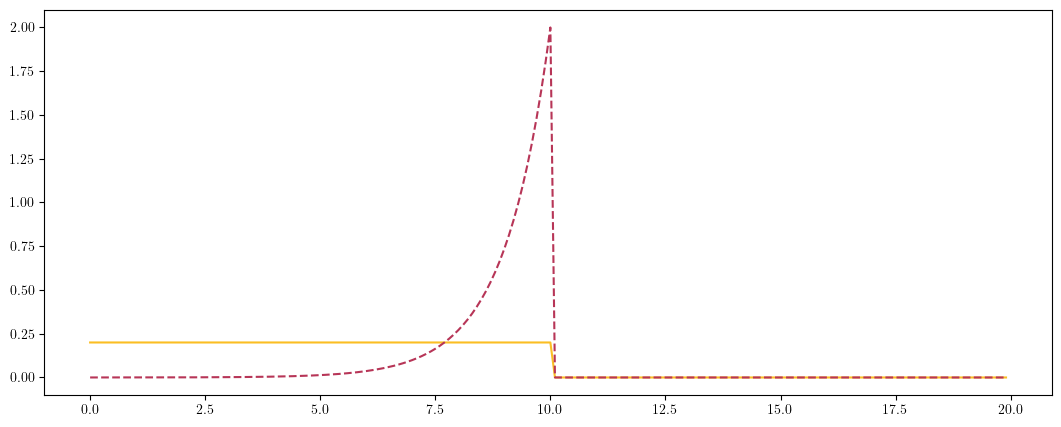

In [16]:
fig, axs = plt.subplots(1, figsize=(13,5))
gs = gridspec.GridSpec(1, 1, wspace = 0.4, hspace=0.3)

number_colors = len(3*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))


axs.plot(t_range3, 2*np.array(square_pulse)**2, color= colors[0], label = r'$\vert \alpha = 1\rangle$ : Square')
axs.plot(t_range3, 2*np.array(rising_pulse)**2, '--', color= colors[4], label = r'$\vert \alpha = 1\rangle$ : Rising ')
axs.plot(t_range3, 2*np.array(decreasing_pulse)**2, color= colors[8], label = r'$\vert \alpha = 1\rangle$ : Decreasing')

axs.set_xlabel('$\gamma t$',fontsize = font_Size)
axs.set_ylabel(r'$\alpha(t)$',fontsize = font_Size)
axs.tick_params(axis='x', labelsize = font_Size)
axs.tick_params(axis='y', labelsize = font_Size)

axs.axhline(1, color = "black")

axs.legend(fontsize = font_Size, loc = 'center right')

plt.savefig('Figure-panels/Pulse-shapes-in-time.pdf',bbox_inches='tight')
plt.show()

## 3.2 Excitation probability as a function of the pulse shape

NameError: name 'E_range_fine' is not defined

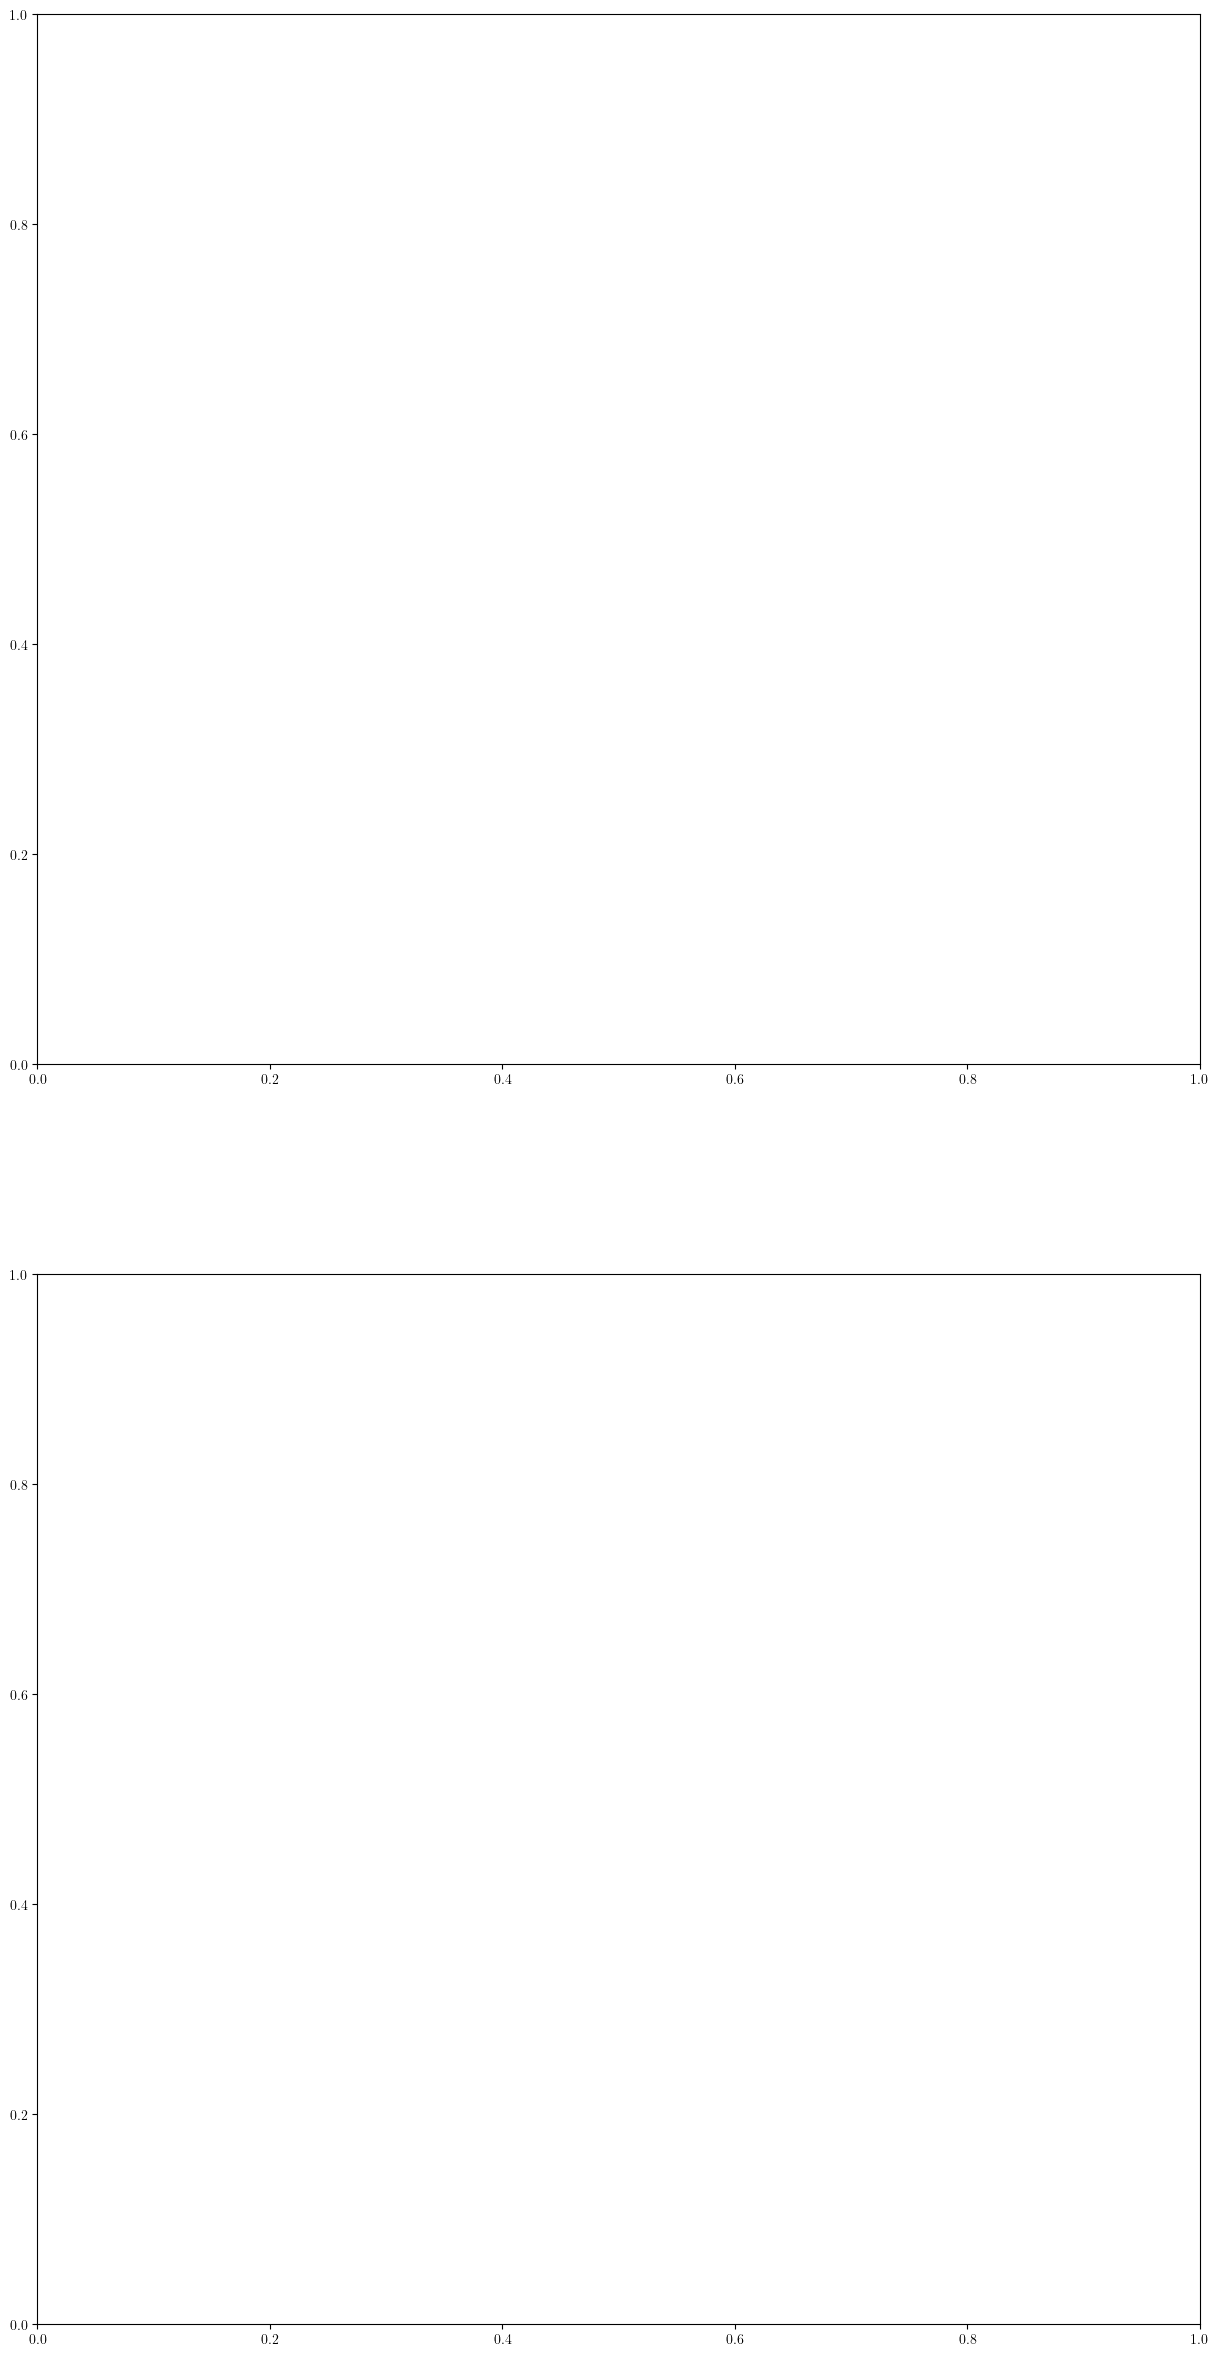

In [17]:
fig, axs = plt.subplots(len(Γ_range), figsize=(15,30))
gs = gridspec.GridSpec(len(Γ_range), 1, wspace = 0.4, hspace=0.3)

number_colors = len(4*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))

for j, G in enumerate([1]):
    E=E_range_fine[0]
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_square[Γ,E], color= colors[1], label = r'Square pulse')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_rising[Γ,E], '--', color= colors[4], label = r'Rising exponential')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_decreasing[Γ,E], '--', color= colors[6], label = r'Decreasing exponential')
    
    axs[j].plot(Pe_SPP_inc[0] + 10/γ, Pe_SPP_inc[1], '-o', color= colors[8], label = r'Increasing SPP')
    axs[j].plot(Pe_SPP_dec[0], Pe_SPP_dec[1], '-*', color= colors[11], label = r'Decreasing SPP')
    
    
    axs[j].set_xlabel('$\gamma t$',fontsize = 22)
    axs[j].set_ylabel(r'$P_e$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)
    
    axs[j].axhline(0, color = 'black',linestyle = '--')
    #axs[j].axhline(1, color = 'black',linestyle = '--')
    
    axs[j].set_xlim((0, 20))
    
    axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)
    
    axs[j].set_position(gs[j].get_position(fig))

axs[0].legend(fontsize=20, loc = 'center right')

plt.savefig('Figure-panels/Pe-vs-time.pdf',bbox_inches='tight')
plt.show() 

## 3.3 Pulse shape and excitation probability

NameError: name 'E_range_fine' is not defined

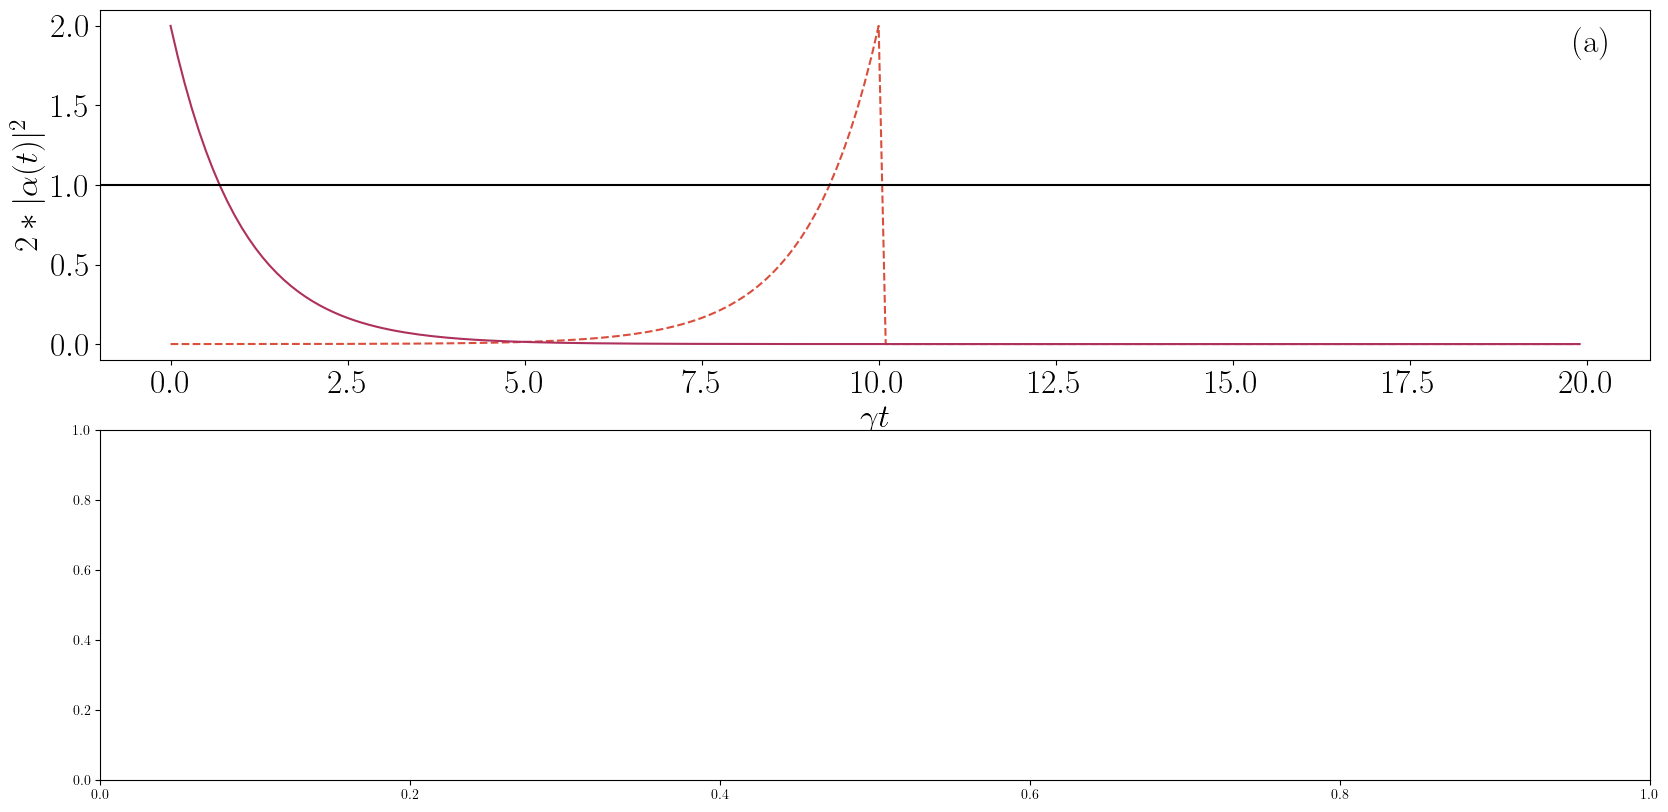

In [18]:
fig, axs = plt.subplots(2, figsize=(20,10))
gs = gridspec.GridSpec(1, 2, wspace = 0.4, hspace=0.3)

number_colors = len(4*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))


#axs[0].plot(t_range3, square_pulse, color= colors[1], label = r'$\vert \alpha = 1\rangle$ : Square')
axs[0].plot(t_range3, 2*np.array(rising_pulse)**2, '--', color= colors[4], label = r'$\vert \alpha = 1\rangle$ : Rising ')
axs[0].plot(t_range3, 2*np.array(decreasing_pulse)**2, color= colors[6], label = r'$\vert \alpha = 1\rangle$ : Decreasing')

axs[0].set_xlabel('$\gamma t$',fontsize = font_Size)
axs[0].set_ylabel(r'$2*\vert\alpha(t)\vert^2$',fontsize = font_Size)
axs[0].tick_params(axis='x', labelsize = font_Size)
axs[0].tick_params(axis='y', labelsize = font_Size)

axs[0].axhline(1, color = "black")

#axs.set_xlim((-0.1, 20/G))
#axs[j].annotate(r'$\Gamma=$'+str(G)+r'$\gamma$', xy=(0.75,0.9), xycoords= 'axes fraction',fontsize=24)

#axs[j].set_position(gs[j].get_position(fig))

axs[0].annotate('('+alphabet[0]+')', xy=(0.95,0.88), xycoords= 'axes fraction',fontsize = font_Size)

#axs[0].legend(fontsize = 22, loc = 'center right')


E=E_range_fine[0]
#axs[1].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_square[Γ,E], color= colors[1], label = r'$\vert \alpha = 1\rangle$ : Square')
axs[1].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_rising[Γ,E], '--', color= colors[4], label = r'$\vert \alpha = 1\rangle$ : Rising')
axs[1].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_decreasing[Γ,E], color= colors[6], label = r'$\vert \alpha = 1\rangle$ : Decreasing')

axs[1].plot(Pe_SPP_inc[0] + 10/γ, Pe_SPP_inc[1], '-o', color= colors[8], label = r'$\vert n = 1\rangle$ :Increasing ')
axs[1].plot(Pe_SPP_dec[0], Pe_SPP_dec[1], '-*', color= colors[11], label = r'$\vert n = 1\rangle$ : Decreasing')


axs[1].set_xlabel('$\gamma t$',fontsize = font_Size)
axs[1].set_ylabel(r'$P_e$',fontsize = font_Size)
axs[1].tick_params(axis='x', labelsize = font_Size)
axs[1].tick_params(axis='y', labelsize = font_Size)

axs[1].axhline(0, color = 'black',linestyle = '--')
#axs[j].axhline(1, color = 'black',linestyle = '--')

axs[1].set_xlim((0, 20))

axs[1].annotate('('+alphabet[1]+')', xy=(0.95,0.88), xycoords= 'axes fraction',fontsize = font_Size)

#axs[j].set_position(gs[j].get_position(fig))

axs[1].legend(fontsize = font_Size, loc = 'center right')

plt.savefig('Figure-panels/Pulse-shapes-and-Pe-time.jpg',bbox_inches='tight')
plt.show() 

In [19]:
# Γ range 
Γ_range = [1/2, 1]
Γ_range_fine = [1/np.sqrt(E/(2*(36/γ))) for E in E_range_fine]

NameError: name 'E_range_fine' is not defined

In [20]:
Γ_range_fine[0]

NameError: name 'Γ_range_fine' is not defined

IndexError: index 8 is out of bounds for axis 0 with size 8

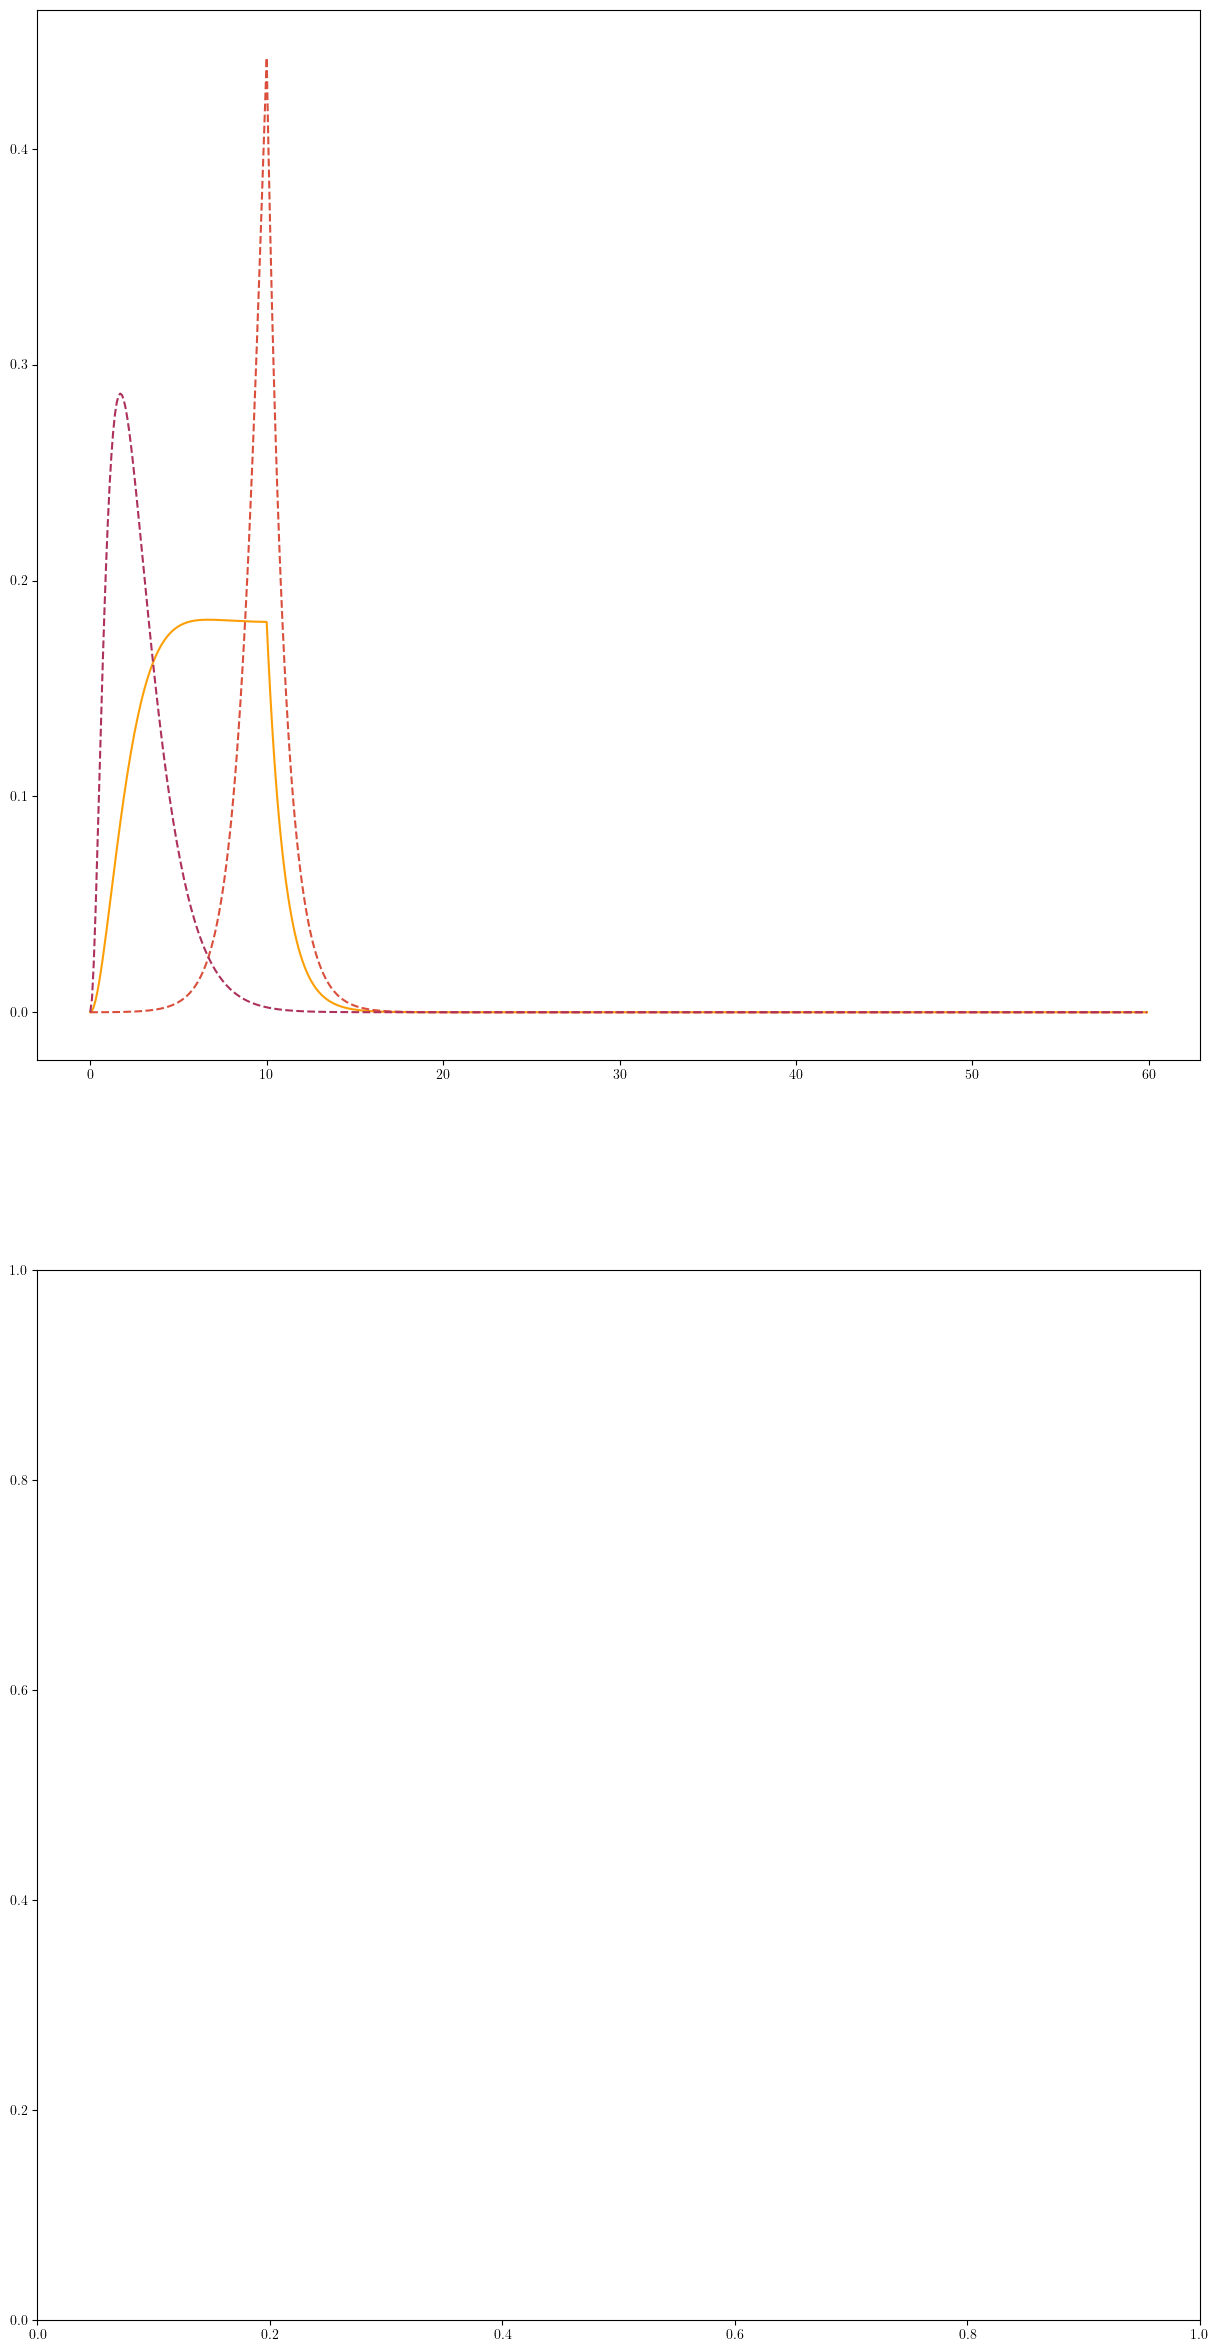

In [21]:
fig, axs = plt.subplots(len(Γ_range), figsize=(15,30))
gs = gridspec.GridSpec(len(Γ_range), 1, wspace = 0.4, hspace=0.3)

number_colors = len(4*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))


for j, G in enumerate([1]):
    
    
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_square[Γ,E], color= colors[1], label = r'Square pulse')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_rising[Γ,E], '--', color= colors[4], label = r'Rising exponential')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Pe_decreasing[Γ,E], '--', color= colors[6], label = r'Decreasing exponential')
    
    axs[j].plot(Pe_SPP_inc[0] + 10/γ, Pe_SPP_inc[1], '-o', color= colors[8], label = r'Increasing SPP')
    axs[j].plot(Pe_SPP_dec[0], Pe_SPP_dec[1], '-*', color= colors[11], label = r'Decreasing SPP')
    
    
    axs[j].set_xlabel('$\gamma t$',fontsize = 22)
    axs[j].set_ylabel(r'$P_e$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)
    
    axs[j].axhline(0, color = 'black',linestyle = '--')
    #axs[j].axhline(1, color = 'black',linestyle = '--')
    
    axs[j].set_xlim((0, 20))
    
    axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)
    
    axs[j].set_position(gs[j].get_position(fig))

axs[0].legend(fontsize=20, loc = 'center right')

plt.savefig('Figure-panels/Pe-vs-time.pdf',bbox_inches='tight')
plt.show() 

## 2. Pre-measurement analysis

## 2.1 Coherence in the spin basis or qBhat 

IndexError: index 8 is out of bounds for axis 0 with size 8

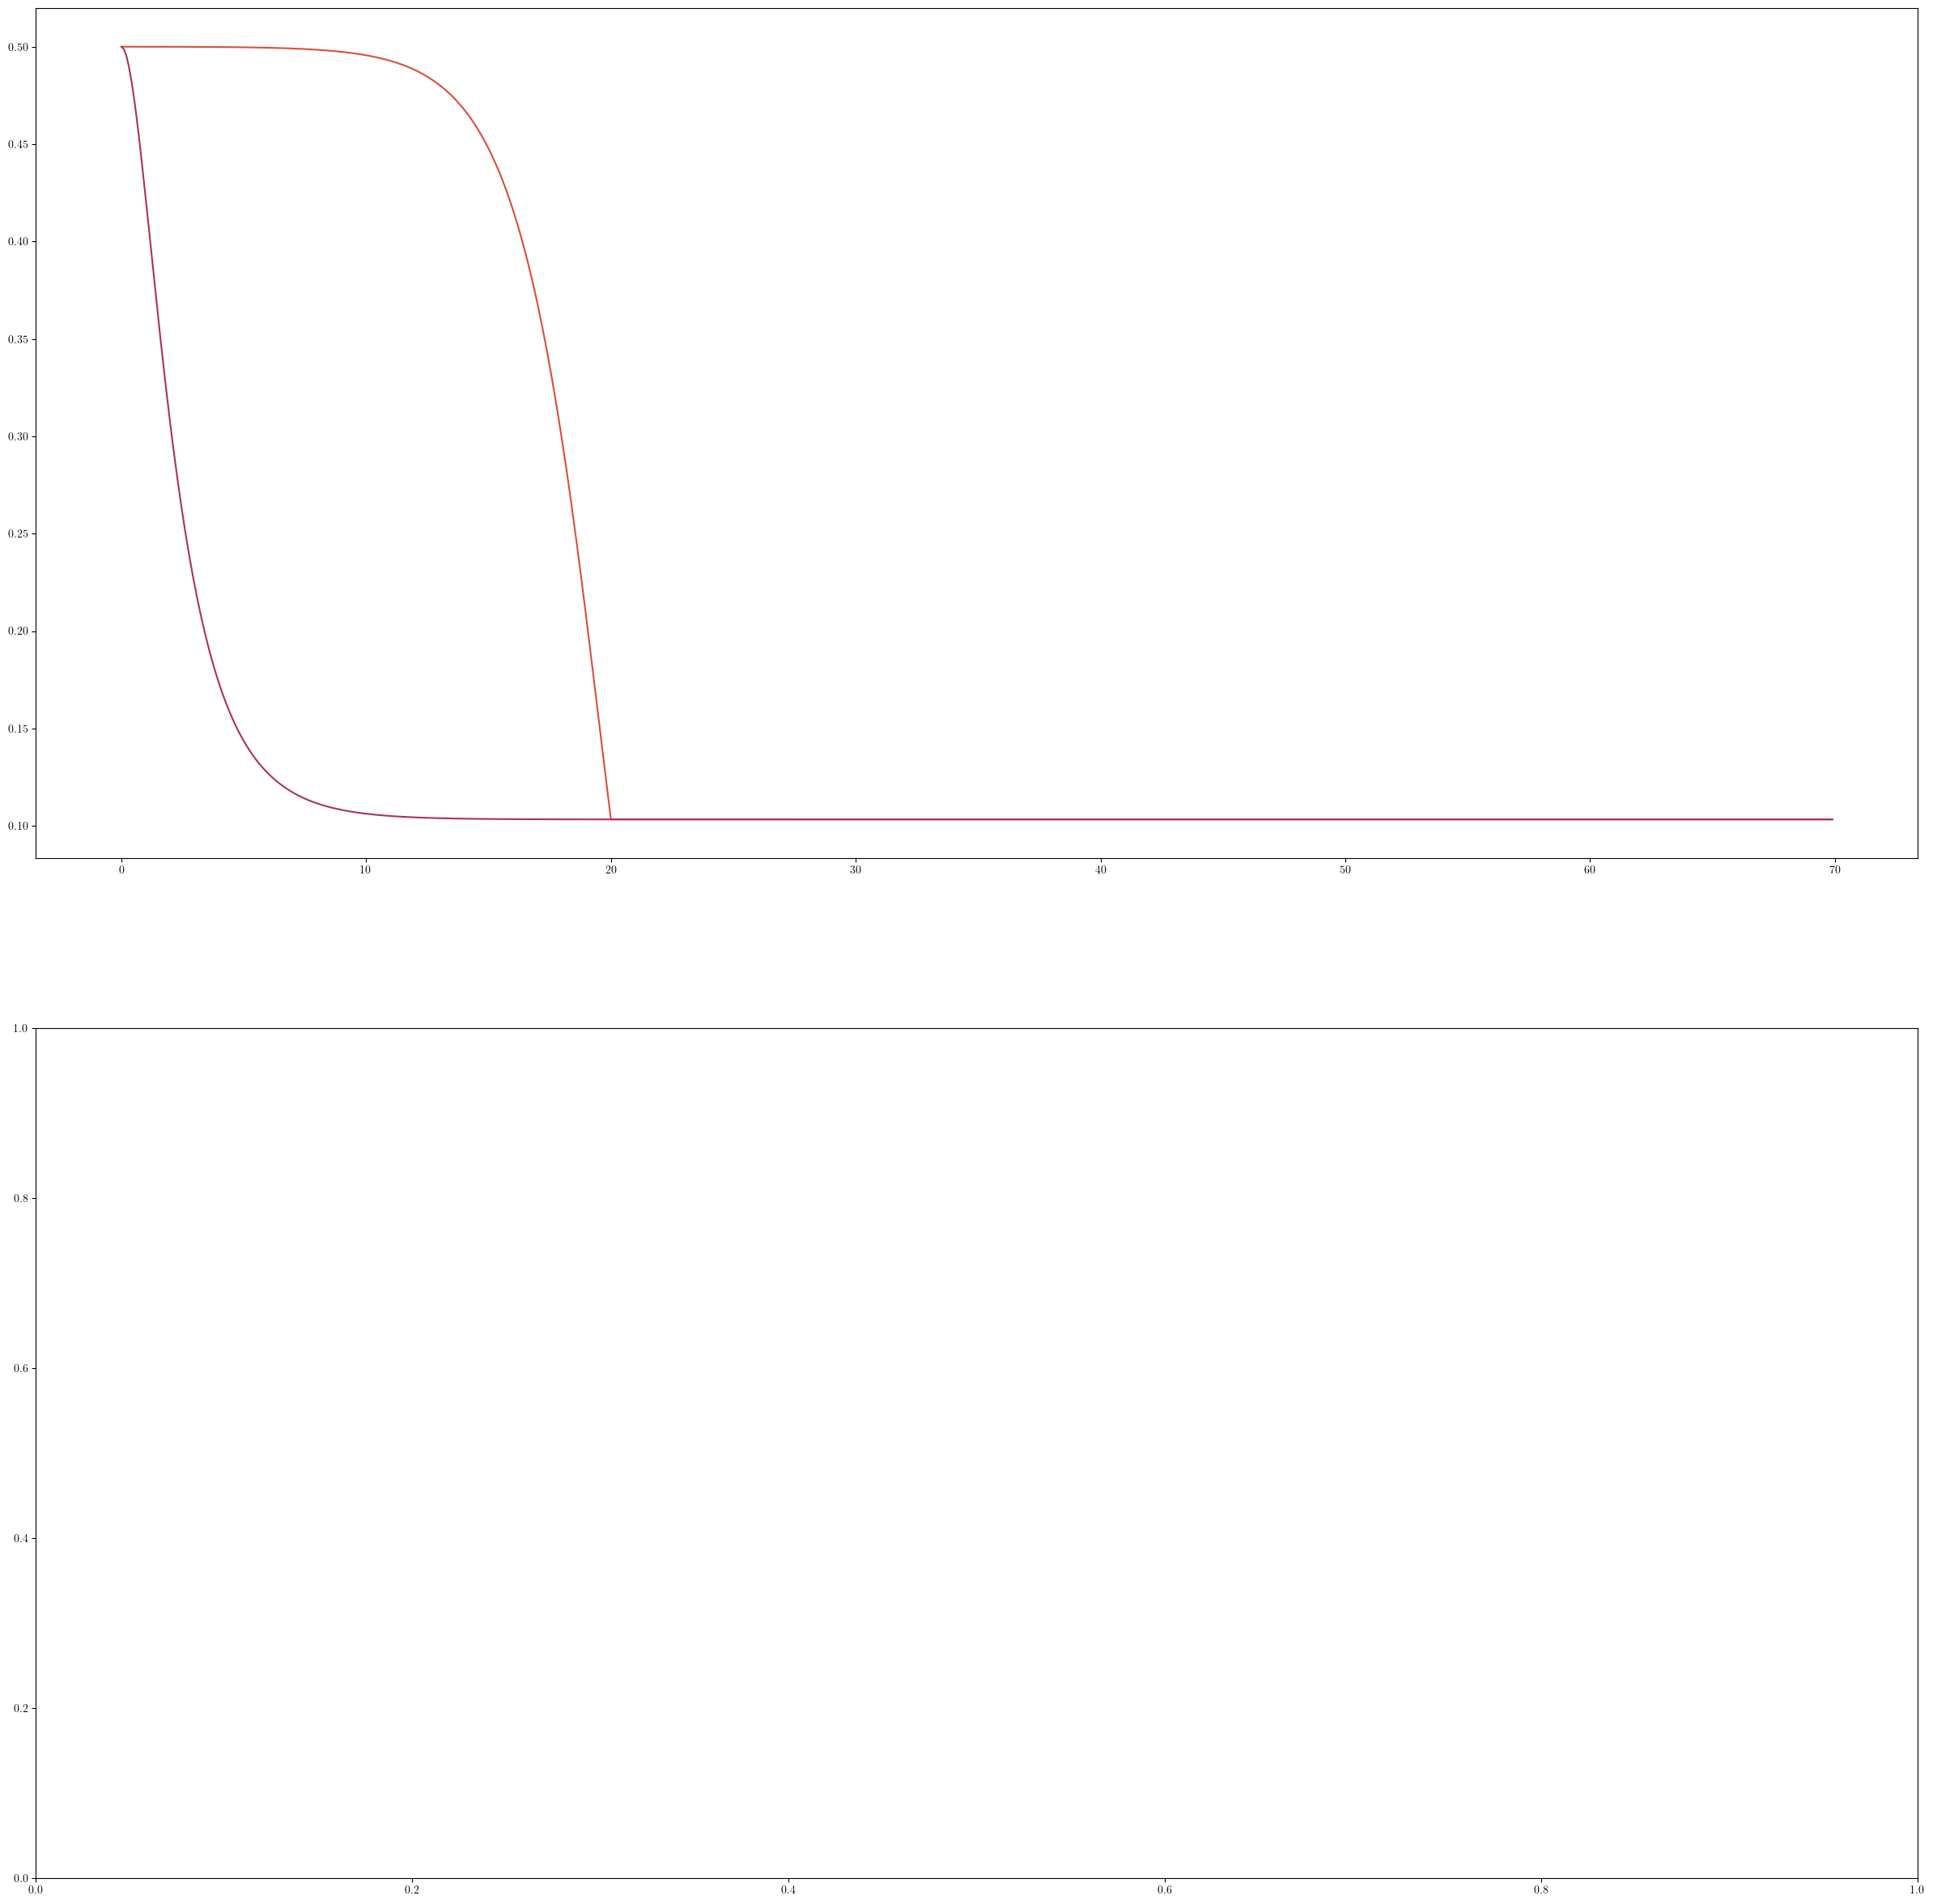

In [23]:
fig, axs = plt.subplots(len(Γ_range), figsize=(30,30))
gs = gridspec.GridSpec(len(Γ_range), 3, wspace = 0.4, hspace=0.3)

number_colors = len(4*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))

for j, Γ in enumerate(Γ_range):
    E = E_range[0]
    #axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Supdw_square[Γ, E], color= colors[0], label = r'$\vert \alpha = 1\rangle$ : Square')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Supdw_rising[Γ, E], color= colors[4], label = r'$\vert \alpha = 1\rangle$ : Rising ')
    axs[j].plot(np.arange(0, 50/γ + 10/Γ, 0.1), Supdw_decreasing[Γ, E], color= colors[6], label = r'$\vert \alpha = 1\rangle$ : Decreasing')
    
    axs[j].plot(Supdw_SPP_inc[0] + 10, Supdw_SPP_inc[1], '-o', color= colors[8], label = r'$\vert n = 1\rangle$ : Increasing')
    axs[j].plot(Supdw_SPP_dec[0] , Supdw_SPP_dec[1], '-*', color= colors[11], label = r'$\vert n = 1\rangle$ : Decreasing')
    
    
    axs[j].set_xlabel('$\gamma t$',fontsize = font_Size)
    axs[j].set_ylabel(r'$S_{\uparrow\downarrow}$',fontsize = font_Size)
    axs[j].tick_params(axis='x', labelsize = font_Size)
    axs[j].tick_params(axis='y', labelsize = font_Size)
    
    axs[j].axhline(0, color = 'black',linestyle = '--')
    axs[j].axhline(1/2, color = 'black',linestyle = '--')
    
    #axs[j].set_xlim((-0.1, 30/G))
    #axs[j].annotate(r'$\Gamma=$'+str(G)+r'$\gamma$', xy=(0.75,0.9), xycoords= 'axes fraction',fontsize=24)
    
    axs[j].set_position(gs[j].get_position(fig))
    
    axs[j].annotate('('+alphabet[j]+')', xy=(0.85,0.88), xycoords= 'axes fraction',fontsize = font_Size)

axs[-1].legend(fontsize = font_Size, loc = 'center right')

plt.savefig('Figure-panels/Supdw-vs-time.pdf',bbox_inches='tight')
plt.show() 

NameError: name 'E_range_fine' is not defined

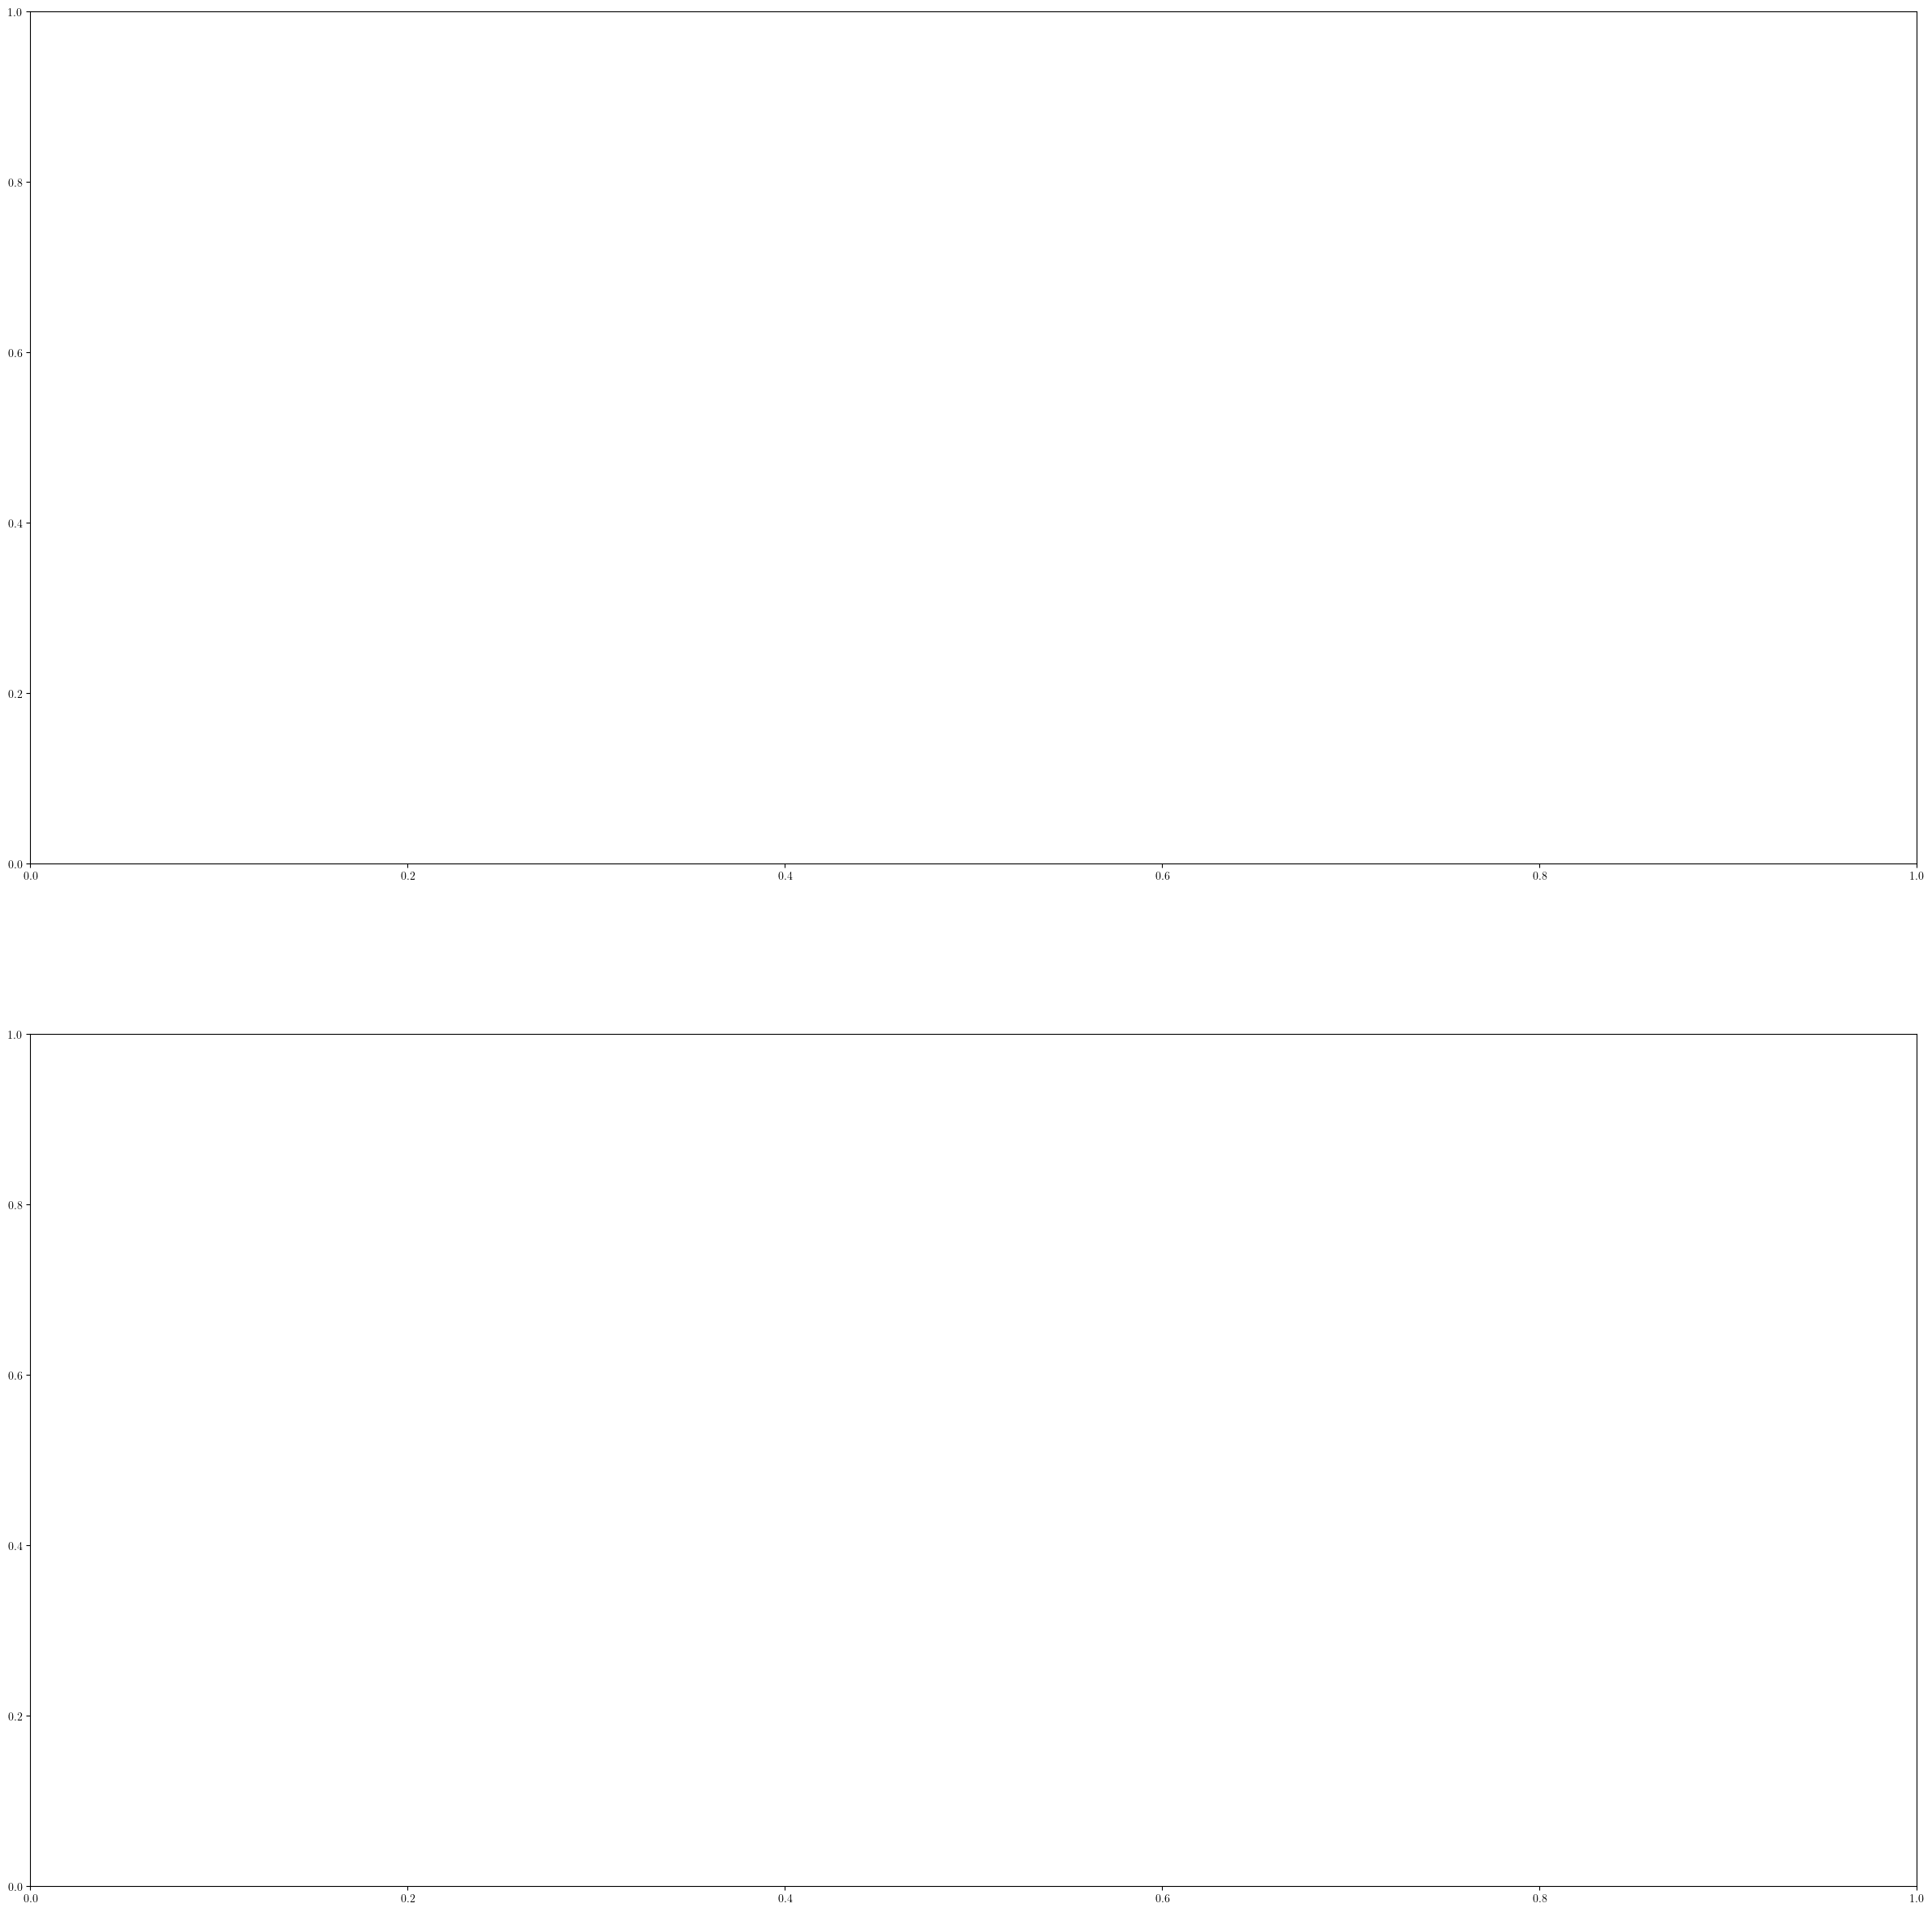

In [24]:
fig, axs = plt.subplots(len(Γ_range), figsize=(30,30))
gs = gridspec.GridSpec(len(Γ_range), 3, wspace = 0.4, hspace=0.3)

number_colors = len(3*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))

FINAL_Supdw_square = dict()
FINAL_Supdw_rising = dict()
FINAL_Supdw_decreasing = dict()

for Γ in Γ_range:
    FINAL_Supdw_square[Γ] = [Supdw_square[Γ, E][-1] for E in E_range_fine]
    FINAL_Supdw_rising[Γ] = [Supdw_rising[Γ, E][-1] for E in E_range_fine]
    FINAL_Supdw_decreasing[Γ] = [Supdw_decreasing[Γ, E][-1] for E in E_range_fine]

for j, Γ in enumerate(Γ_range):
    axs[j].plot(E_range_fine, FINAL_Supdw_square[Γ], color= colors[0], label = r'$\vert \alpha = 1\rangle$ : Square')
    axs[j].plot(E_range_fine, FINAL_Supdw_rising[Γ], color= colors[8], label = r'$\vert \alpha = 1\rangle$ : Rising')
    axs[j].plot(E_range_fine, FINAL_Supdw_decreasing[Γ],'--', color= colors[4], label = r'$\vert \alpha = 1\rangle$ : Decreasing')
    
    axs[j].set_xlabel('$E$',fontsize = 22)
    axs[j].set_ylabel(r'$S_{\uparrow\downarrow}(\infty)$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)
    
    axs[j].axhline(0, color = 'black',linestyle = '--')
    axs[j].axhline(1, color = 'black',linestyle = '--')
    
    axs[j].set_xlim((0.9, 4.2))
    #axs[j].annotate(r'$\Gamma=$'+str(G)+r'$\gamma$', xy=(0.75,0.9), xycoords= 'axes fraction',fontsize=24)
    
    axs[j].set_position(gs[j].get_position(fig))
    
    axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)

axs[-1].legend(fontsize=20, loc = 'center right')

#plt.savefig('Figure-panels/Supdw-steady-state-vs-energy.pdf',bbox_inches='tight')
plt.show() 

## 3. Measurement analysis

In [25]:
def In_out_intensity(σ, ρ, pulse):
    
    return np.abs(pulse)**2 + γ*(σ.dag()*σ*ρ).tr() - 2*np.sqrt(γ)*np.real((σ.dag()*ρ).tr()*pulse)

In [26]:
def α_dec(t,E,Γ):
    return np.sqrt(E)*(2**-0.5)*np.sqrt(Γ)*np.exp(-(t/2)*Γ)

The following functions inplement the section "Polarization and amplitude of the output field" of the thesis/paper.

In [27]:
def Intensities_coherent_drive(States, t_range, γ, Γ, E, pulse_profile): # This needs adaptation!
    """
    Intensities of a coherent pulse
    
    Parameters
    
    -----------
    
    States : qobj, Density matrix
    
    t_range : list of times
    
    γ : float, the dissipation rate (=1 by defaul)
    
    Γ : float, the frequency of the pulse (inverse of the pulse duration τp)
    
    E : float, the (mean) energy of the pulse, i.e., mean photon number
    
    pulse_profile : if rising_pulse, decreasing_pulse or square_pulse
    
    
    
    Returns
    -----------
    
    List : Intensities_vec
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot, b_R_out, b_L_out]
    
    """
    
    time_index = np.arange(0, len(t_range))
    
    # Starts a list of the pulse shape
    ε = []
    
    # For each state, compute the probability of being in the ground or excited states
    Pg = [(σ_R*σ_Rd*States[j]).tr() for j in time_index]
    
    Pe = [(σ_Rd*σ_R*States[j]).tr() for j in time_index]
    
    # Compute the coherence in σR 
    s_m = [(σ_R*States[j]).tr() for j in time_index]
    
    # Defines the pulse profile in polarization j=R,L
    if pulse_profile == 'decreasing_pulse':
        #print('decreasing')
        
        for t in t_range:
            ε.append(np.sqrt(E*Γ)*np.exp(-(t/2)*Γ))
            #ε.append(np.sqrt(E*Γ/2)*np.exp(-(t/2)*Γ))
            
    
    if pulse_profile == 'rising_pulse':
        
        for t in t_range:
            #print('rising')
            if t < 0:
                ε.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ))
                #ε.append(np.sqrt(E*Γ/2)*np.exp((t/2)*Γ))
            else:
                ε.append(0)
            
        
    if pulse_profile == 'square_pulse':
        #print('square')
        
        for t in t_range:
            if t < 0:
                ε.append(np.sqrt((E)*Γ/10))
                #ε.append(np.sqrt((E/2)*Γ/10))
            else:
                ε.append(0)
                
    # Compute the output fields in R and L from the input-output relations
    b_R_out = [ε[j] - np.sqrt(γ)*s_m[j] for j in time_index]
    
    b_L_out = [ε[j] for j in time_index]
    
    #List of I_R in time
    I_r_up = [np.abs(ε[j])**2 + γ*Pe[j] - 2*γ**0.5*np.real(ε[j]*np.conj(s_m[j])) for j in time_index] #ok
    
    #List of I_L in time
    I_l_up = [np.abs(ε[j])**2 for j in time_index] #ok
    
    #List of Total intensity I_tot in time
    I_tot = [I_l_up[j] + I_r_up[j] for j in time_index] #ok
    
    Half_I_tot = [(I_r_up[j] + I_l_up[j])/2  for j in time_index]
    
    I_h_up = [Half_I_tot[j] + np.abs(ε[j])**2 - (γ**0.5*np.real(ε[j]*np.conj(s_m[j]))) for j in time_index] #ok
    I_v_up = [Half_I_tot[j] - np.abs(ε[j])**2 + ((γ**0.5*np.real(ε[j]*np.conj(s_m[j])))) for j in time_index] #ok
    
    #This ones I've corrected the last term, the conjugation was in the amplitude
    I_a_up = [Half_I_tot[j] + ((γ**0.5*np.imag(ε[j]*np.conj(s_m[j])))) for j in time_index] 
    I_d_up = [Half_I_tot[j] - ((γ**0.5*np.imag(ε[j]*np.conj(s_m[j])))) for j in time_index]
    
    Intensities_vec = [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot, b_R_out, b_L_out]
    
    return Intensities_vec

def Angles_βξ(Intensities_vec):
    """
    Angles_βξ - general for coherent drive or spp
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    
    
    Returns
    -----------
    
    List : β up [0] and down [1] and ξ up [2] and down [3]
    
    
    """
    
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot] = [Intensities_vec[0], Intensities_vec[1], Intensities_vec[2], Intensities_vec[3], Intensities_vec[4], Intensities_vec[5], Intensities_vec[6]]
    
    time_index = np.arange(0, len(I_r_up))
    
    # To compute the angles we take advantage of the symmetry between R and L.
    
    μ_x_up = μ_x_dw =  np.array([(I_h_up[j] - I_v_up[j]) / I_tot[j] for j in time_index]) #ok
    
    μ_y_up = np.array([(I_a_up[j] - I_d_up[j]) / I_tot[j] for j in time_index])#ok
    μ_y_dw = -μ_y_up #ok
    
    μ_z_up = np.array([(I_r_up[j] - I_l_up[j]) / I_tot[j] for j in time_index])#ok
    μ_z_dw = -μ_z_up #ok
    
    # β = θ angle
    β_up = [np.arccos(μ_z_up[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    β_dw = [np.arccos(μ_z_dw[j]/ np.sqrt(μ_x_dw[j]**2 + μ_y_dw[j]**2 + μ_z_dw[j]**2)) for j in time_index]
    
    # ξ = ζ angle
    ξ_up = [np.arctan(μ_y_up[j]/μ_x_up[j]) for j in time_index]
    ξ_dw = [np.arctan(μ_y_dw[j]/μ_x_dw[j]) for j in time_index]
    
    return [β_up, β_dw, ξ_up, ξ_dw]

def Angles_βξ_modified(Intensities_vec):
    """
    Angles_βξ
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    
    
    Returns
    -----------
    
    List : β up [0] and down [1] and ξ up [2] and down [3]
    
    
    """
    
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot] = [Intensities_vec[0], Intensities_vec[1], Intensities_vec[2], Intensities_vec[3], Intensities_vec[4], Intensities_vec[5], Intensities_vec[6]]
    
    time_index = np.arange(0, len(I_r_up))
    
    μ_x_up = μ_x_dw = μ_y_up = μ_y_dw = μ_z_up = μ_z_dw = β_up = β_dw = ξ_up = ξ_dw =  []
    
    for j in time_index:
    
        if (I_h_up[j] - I_v_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_x_up.append((I_h_up[j] - I_v_up[j]) / I_tot[j])
            μ_x_dw.append((I_h_up[j] - I_v_up[j]) / I_tot[j])
            
        else:
            μ_x_up.append(0)
            μ_x_dw.append(0)
            
    
        if (I_a_up[j] - I_d_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_y_up.append((I_a_up[j] - I_d_up[j]) / I_tot[j])
            μ_y_dw.append(-(I_a_up[j] - I_d_up[j]) / I_tot[j])
            
        else:
            μ_y_up.append(0)
            μ_y_dw.append(0)
    
    
        if (I_r_up[j] - I_l_up[j]) > 10**-5 and I_tot[j] > 10**-5:
            μ_z_up.append((I_r_up[j] - I_l_up[j]) / I_tot[j])
            μ_z_dw.append(-(I_r_up[j] - I_l_up[j]) / I_tot[j])
            
        else:
            μ_z_up.append(0)
            μ_z_dw.append(0)
            
        if μ_x_up[j] > 0 and μ_x_dw[j] > 0:
            ξ_up.append(np.arctan(μ_y_up[j]/μ_x_up[j]))
            ξ_dw.append(np.arctan(μ_y_dw[j]/μ_x_dw[j]))
            
        else : 
            ξ_up.append(np.arctan(1))
            ξ_dw.append(np.arctan(1))

    β_up = [np.arccos(μ_z_up[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    β_dw = [np.arccos(μ_z_dw[j]/ np.sqrt(μ_x_up[j]**2 + μ_y_up[j]**2 + μ_z_up[j]**2)) for j in time_index]
    #print("μz = "+str(μ_z_up[j]))
    
    
    return [β_up, β_dw, ξ_up, ξ_dw]

In [28]:
###################################################################################################
#    
#     Static Poincaré sphere
# 
###################################################################################################
def Poincare_vectors(Intensities_vec):
    
    """
    Poincaré vectors and Stokes parameters
    
    Parameters
    -----------
    
    Intensities_vec: list of the intensities
    
    
    
    Returns
    -----------
    
    List : Poincaré vectors up [0] and down [1] and the Stokes parameters
    
    
    """
    
    [I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot] = [Intensities_vec[0], Intensities_vec[1], Intensities_vec[2], Intensities_vec[3], Intensities_vec[4], Intensities_vec[5], Intensities_vec[6]]
    
    time_index = np.arange(0, len(I_r_up))  
    
    μ_x_up = [(I_h_up[j] - I_v_up[j]) / I_tot[j] for j in time_index]
    
    μ_y_up = [(I_a_up[j] - I_d_up[j]) / I_tot[j] for j in time_index]
    
    μ_z_up = [(I_r_up[j] - I_l_up[j]) / I_tot[j] for j in time_index] 
    
    S_up = [[μ_x_up[j], μ_y_up[j], μ_z_up[j]] for j in time_index]
    
    # Taking advantage of the symmetry to compute the vector for the down component
    S_dw = [[μ_x_up[j], -μ_y_up[j], -μ_z_up[j]] for j in time_index]
    
    return [S_up, S_dw, μ_x_up, μ_y_up, μ_z_up, I_tot]
    

def Static_Poincare_sphere(states, vector_color_list, S_up_or_dw, save = True, path_and_filename_dot_pdf = 'unamed_sphere.pdf', view = [-40,30]):
    b = Bloch()

    b.view = view

    images=[]

    try:

        length = len(states)

    except:

        length = 1

        states = [states]
        
    b.xlabel= [r'$\left|H\right>$', r'$\left|V\right>$']
    # I'm interested just in the H-R plane, hence I do this trick by hand, but could be better implemented.
    b.ylabel= ['', ''] #[r'$\left|A\right>$', r'$\left|D\right>$']
    b.zlabel= [r'$\left|R\right>$', r'$\left|L\right>$']
    
    for i in range(length):
        if i == 0 :
            if S_up_or_dw == 'up':
                b.vector_color = ['purple', 'b']
            if S_up_or_dw == 'down':
                b.vector_color = ['purple', 'r']
            b.add_vectors(states[i]) 
            
        elif i == len(states)-1 :
            #b.vector_color = ['r']
            b.add_vectors(states[i]) 
            
        else:
            b.point_color = vector_color_list
            b.add_points(states[i])
        
    if save == True:
        b.save(path_and_filename_dot_pdf)
    
    b.render()

The mean value of the output field, for each polarization $j$ is given by
\begin{align}
\langle(b_{j}^{\text{out}})^{\dagger}b_{j}^{\text{out}}\rangle & =\langle(b_{j}^{\text{in}})^{\dagger}b_{j}^{\text{in}}\rangle+\gamma\langle\sigma_{j}^{\dagger}\sigma_{j}\rangle-2\sqrt{\gamma}\Re\left\{ \langle\sigma_{j}^{\dagger}(t)b_{j}^{\text{in}}(t)\rangle\right\}.
\end{align}

In [29]:
tf = 30
Δt = 0.1
t_list = np.arange(0, tf + Δt, Δt)

In [30]:
αd_list = [α_dec(t,1,1) for t in t_list]

In [31]:
E_range = [np.sqrt(2), 2]

In [32]:
Γ_range = [10**(-2), 1]

In [33]:
%%time
############################################################################
# Decreasing exponential pulses simulations
############################################################################

t_range = dict()

# Computation for the Decreasing exponential pulse

# Starts the dictionary that keeps track of the states
States_decreasing = dict()
States_decreasing_up = dict()
States_decreasing_dw = dict()

# States the dictionary for the probabilities of ground and excited states.
Pg_decreasing = dict()
Pe_decreasing = dict()

# Famous qBhat
Supdw_decreasing = dict()

#vN_decreasing = dict()

Expec_decreasing = dict()

Intensities_decreasing = dict()
Intensities_decreasing_up = dict()
Intensities_decreasing_dw = dict()

for E in E_range:
    
    for Γ in Γ_range:
        
        par_decreasing = {'Gamma' : Γ, 'Energy' : E, 'Pulse_profile' : 'decreasing_pulse'}
        
        t_range[Γ] = np.arange(0, 20/Γ, γ/100)
        
        States_decreasing[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψ0, t_range[Γ], c_ops, args = par_decreasing)
        
        statesare = States_decreasing[Γ, E].states
        
        Intensities_decreasing[Γ, E] = Intensities_coherent_drive(statesare, t_range[Γ], γ, Γ, E, 'decreasing_pulse')
        
        # Starting from spin up
        #print(1)
        States_decreasing_up[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψup, t_range[Γ], c_ops, args = par_decreasing)
        #print(12)
        statesare_up = States_decreasing_up[Γ, E].states
        #print(3)
        Intensities_decreasing_up[Γ, E] = Intensities_coherent_drive(statesare_up, t_range[Γ], γ, Γ, E, 'decreasing_pulse')
        #print(4)
        # Starting from spin down
        
        States_decreasing_dw[Γ, E] = mesolve(H(Δω, Hp_coeff_t, Hp_coeff_t, γ), Ψdw, t_range[Γ], c_ops, args = par_decreasing)
        
        statesare_dw = States_decreasing_dw[Γ, E].states
        
        Intensities_decreasing_dw[Γ, E] = Intensities_coherent_drive(statesare_dw, t_range[Γ], γ, Γ, E, 'decreasing_pulse')
        
        #Pg_decreasing[Γ, E] = [np.real((Π_spin*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Pe_decreasing[Γ, E] = [np.real((Π_trion*statesare[i]).tr()) for i in np.arange(0, len(statesare))]
        
        #Supdw_decreasing[Γ, E] = [np.real((Coh_spin_subspace*statesare[i]).tr())/2 for i in np.arange(0, len(statesare))]
        
        #vN_decreasing[Γ, E] = [entropy_vn(statesare[i].ptrace(1), base=2) for i in np.arange(0, len(statesare))]

CPU times: user 7min 52s, sys: 5.24 s, total: 7min 57s
Wall time: 7min 55s


In [34]:
I_R = [output_intensity(σ_R, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]
I_L = [output_intensity(σ_L, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]
I_H = [output_intensity(σ_H, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]
I_V = [output_intensity(σ_V, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]
I_A = [output_intensity(σ_A, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]
I_D = [output_intensity(σ_D, statesare[i], αd_list[i]) for i in np.arange(0,len(αd_list))]

NameError: name 'output_intensity' is not defined

In [ ]:
fig, axs = plt.subplots(4, figsize=(15,10))
gs = gridspec.GridSpec(nrows = 4, ncols = 1, wspace = 1, hspace=1)

number_colors = len(10*Γ_range)
colors = plt.cm.inferno(np.linspace(0.4,0.85,number_colors))

axs[0].plot(t_plots, I_r_up, color= colors[1], label = r'$I^\uparrow_R$')
axs[0].plot(t_plots, I_l_up, color= colors[8], label = r'$I^\uparrow_L$')

axs[1].plot(t_plots, I_h_up, color= colors[4], label = r'$I^\uparrow_H$')
axs[1].plot(t_plots, I_v_up, color= colors[12], label = r'$I^\uparrow_V$')
            
axs[2].plot(t_plots, I_a_up, color= colors[16], label = r'$I^\uparrow_A$')
axs[2].plot(t_plots, I_d_up, color= colors[20], label = r'$I^\uparrow_D$')

axs[3].plot(t_plots, I_tot, '-o', color= colors[8], label = r'$I^{Tot}$')



for j in [0,1,2,3]:
    axs[j].set_xlabel('$\gamma t$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)

    axs[j].axhline(0, color = 'black',linestyle = '--')
    
    axs[j].legend(fontsize=20, loc = 'center right')
    
    axs[j].set_xlim((0, 6))
    #axs[j].set_yscale('log')

#axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)

#axs[j].set_position(gs[j].get_position(fig))

plt.savefig('Figure-panels/Intensities-coh-vs-time.png',bbox_inches='tight')
plt.show()

In [ ]:
t_plots = t_range[1]
[I_r_up, I_l_up, I_h_up, I_v_up, I_a_up, I_d_up, I_tot, b_R_out, b_L_out] = Intensities_decreasing_dw[1, 0.5]




In [ ]:
# Monochromatic regime: E = np.sqrt(2) and Γ = 10**-2
[S_up_coh, S_dw_coh, μ_x_up_coh, μ_y_up_coh, μ_z_up_coh, I_tot] = Poincare_vectors(Intensities_decreasing_up[10**(-2), np.sqrt(2)])

[β_up_coh, β_dw_coh, ξ_up_coh, ξ_dw_coh] = Angles_βξ(Intensities_decreasing_up[10**(-2), np.sqrt(2)])




In [ ]:
fig, axs = plt.subplots(3, figsize=(15,10))
gs = gridspec.GridSpec(nrows = 4, ncols = 1, wspace = 1, hspace=1)

number_colors = len(6*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))

axs[0].plot(t_plots, np.array(β_up_coh)/np.pi, color= colors[4], label = r'$\beta_\uparrow/\pi$')
axs[0].plot(t_plots, np.array(β_dw_coh)/np.pi, color= colors[8], label = r'$\beta_\downarrow/\pi$')

axs[1].plot(t_plots, np.array(ξ_up_coh)/np.pi, color= colors[12], label = r'$\xi_\uparrow/\pi$')
axs[1].plot(t_plots, np.array(ξ_dw_coh)/np.pi, color= colors[16], label = r'$\xi_\downarrow/\pi$')

axs[2].plot(t_plots, μ_x_up_coh, color= colors[4], label = r'$\mu_x$')
axs[2].plot(t_plots, μ_y_up_coh, color= colors[6], label = r'$\mu_y$')
axs[2].plot(t_plots, μ_z_up_coh, color= colors[8], label = r'$\mu_z$')
#axs[2].plot(t_plots, μ_z_dw_coh, color= colors[8], label = r'$\beta_\downarrow$')
#axs[3].plot(t_plots, μ_x_dw_co, color= colors[8], label = r'$\beta_\downarrow$')


for j in [0,1,2]:
    axs[j].set_xlabel('$\gamma t$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)

    axs[j].axhline(0, color = 'black',linestyle = '--')
    
    axs[j].legend(fontsize=20, loc = 'center right')
    
    #axs[j].set_xlim((-0.1, 2))
    axs[j].set_ylim((-1.1, 1.1))

axs[2].set_ylim((-1, 1.1))
#axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)

#axs[j].set_position(gs[j].get_position(fig))

plt.savefig('Figure-panels/Angles-coh-vs-time.png',bbox_inches='tight')
plt.show()

In [ ]:
Static_Poincare_sphere(S_up_coh, ['b'], 'up', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_up_cohMonochromaticRegime.png', view = [0,0])
Static_Poincare_sphere(S_dw_coh, ['r'], 'down', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_dw_cohMonochromaticRegime.png', view = [0,0])

In [ ]:
# Pulsed regime: E = 2 and Γ = 1
[S_up_coh, S_dw_coh, μ_x_up_coh, μ_y_up_coh, μ_z_up_coh, I_tot] = Poincare_vectors(Intensities_decreasing_up[1, 1])

[β_up_coh, β_dw_coh, ξ_up_coh, ξ_dw_coh] = Angles_βξ(Intensities_decreasing_up[1, 1])




In [ ]:
fig, axs = plt.subplots(3, figsize=(15,10))
gs = gridspec.GridSpec(nrows = 4, ncols = 1, wspace = 1, hspace=1)

number_colors = len(6*Γ_range)
colors = plt.cm.inferno(np.linspace(0.85,0.4,number_colors))

axs[0].plot(t_plots, np.array(β_up_coh)/np.pi, color= colors[4], label = r'$\beta_\uparrow/\pi$')
axs[0].plot(t_plots, np.array(β_dw_coh)/np.pi, color= colors[8], label = r'$\beta_\downarrow/\pi$')

axs[1].plot(t_plots, np.array(ξ_up_coh)/np.pi, color= colors[12], label = r'$\xi_\uparrow/\pi$')
axs[1].plot(t_plots, np.array(ξ_dw_coh)/np.pi, color= colors[16], label = r'$\xi_\downarrow/\pi$')

axs[2].plot(t_plots, μ_x_up_coh, color= colors[4], label = r'$\mu_x$')
axs[2].plot(t_plots, μ_y_up_coh, color= colors[6], label = r'$\mu_y$')
axs[2].plot(t_plots, μ_z_up_coh, color= colors[8], label = r'$\mu_z$')
#axs[2].plot(t_plots, μ_z_dw_coh, color= colors[8], label = r'$\beta_\downarrow$')
#axs[3].plot(t_plots, μ_x_dw_co, color= colors[8], label = r'$\beta_\downarrow$')


for j in [0,1,2]:
    axs[j].set_xlabel('$\gamma t$',fontsize = 22)
    axs[j].tick_params(axis='x', labelsize=22)
    axs[j].tick_params(axis='y', labelsize=22)

    axs[j].axhline(0, color = 'black',linestyle = '--')
    
    axs[j].legend(fontsize=20, loc = 'center right')
    
    #axs[j].set_xlim((-0.1, 2))
    axs[j].set_ylim((-1.1, 1.1))

axs[2].set_ylim((-1, 1.1))
#axs[j].annotate('('+alphabet[j]+')', xy=(0.05,0.88), xycoords= 'axes fraction',fontsize=22)

#axs[j].set_position(gs[j].get_position(fig))

plt.savefig('Figure-panels/Angles-coh-vs-timePulsedRegime.png',bbox_inches='tight')
plt.show()

In [ ]:
Static_Poincare_sphere(S_up_coh, ['b'], 'up', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_up_cohPulsedRegime.png', view = [0,0])
Static_Poincare_sphere(S_dw_coh, ['r'], 'down', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_dw_cohPulsedRegime.png', view = [0,0])

In [ ]:
def Intensities_single_photon_pulse(t, γ=1):
    
    f1 = np.sqrt(γ)*np.exp(-γ*t/2)
    
    f2 = np.sqrt(γ)*t*np.exp(-γ*t/2)
    
    I_r = (f1 - γ*f2)**2/2
    
    I_l = f1**2/2
    
    Int = f1*(f1 - γ*f2)
   
    return [I_r + I_l, I_r - I_l, Int]

def Poin_vecs_SPP(intensities_vec_t):
    v = intensities_vec_t
    
    S_up = [v[2]/v[0], 0, v[1]/v[0]]
    
    S_dw = [v[2]/v[0], 0, -v[1]/v[0]]
    
    return[S_up, S_dw]

In [ ]:
I_tot_vec = [Intensities_single_photon_pulse(t)[0] for t in t_SPP]

In [ ]:
Poinc_vecs_SPP = Poin_vecs_SPP(I_tot_vec) 

In [ ]:
Poinc_vecs_SPP_list = [Poin_vecs_SPP(Intensities_single_photon_pulse(t, 1)) for t in t_SPP]

In [ ]:
P_up_SPP = [Poinc_vecs_SPP_list[i][0] for i in np.arange(0,len(Poinc_vecs_SPP))]
P_dw_SPP = [Poinc_vecs_SPP_list[i][1] for i in np.arange(0,len(Poinc_vecs_SPP))]

In [ ]:
Static_Poincare_sphere(P_up_SPP, ['b'], 'up', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_up_SPP.pdf', view = [0,0])
Static_Poincare_sphere(P_dw_SPP, ['r'], 'down', save = True, path_and_filename_dot_pdf = 'Figure-panels/S_dw_SPP.pdf', view = [0,0])

In [100]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.7.1
Numpy,1.22.4
SciPy,1.7.3
matplotlib,3.7.1
Cython,0.29.33
Number of CPUs,16
BLAS Info,OPENBLAS
IPython,8.12.0
Python,"3.9.13 (main, Aug 25 2022, 18:29:29) [Clang 12.0.0 ]"
OS,posix [darwin]
